## Anomaly Detection using Transformers

In [135]:
# Imports
import os
import math
import glob
import time
import itertools
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau





In [136]:
# Configuration class
class Config:
    def __init__(self):
        # Paths
        self.base_path = Path(r"C:\Users\House\OneDrive\Documents\Sohan_Arun\BTH Course Work\Deep Learning\Assignment 2")
        self.data_dirs = [self.base_path / "data/train", self.base_path / "data/test"]


        # Model parameters
        self.window_size = 10
        self.stride = 5
        self.overlap = 0.5
        self.batch_size = 32
        self.d_model = 512
        self.n_heads = 8
        self.n_layers = 8
        self.lambda_disc = 0.1
        self.inner_dim = 2048
        
        # Training parameters
        self.num_epochs = 200
        self.learning_rate = 1e-4
        self.percentile = 70
        self.min_anomaly_windows = 100


# Create global config
cfg = Config()


# Set display options for debugging
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

# For reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [137]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        """
        Initialize positional encoding.
        Args:
            d_model (int): Dimension of the model
            max_len (int): Maximum sequence length to pre-compute
        """
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register buffer for persistence but no gradient updates
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: (1, max_len, d_model)

    def forward(self, x):
        """
        Add positional encoding to input tensor.
        Args:
            x (Tensor): Input of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: Output of shape (batch_size, seq_len, d_model)
        """
        return x + self.pe[:, :x.size(1)]





In [138]:
class AnomalyTransformer(nn.Module):
    def __init__(self, 
                 num_features, 
                 d_model=512, 
                 n_heads=8, 
                 n_layers=3, 
                 window_size=200, 
                 inner_dim=2048, 
                 lambda_disc=0.1):
        """
        Initialize Anomaly Transformer.
        Args:
            num_features (int): Number of input features
            d_model (int): Model dimension
            n_heads (int): Number of attention heads
            n_layers (int): Number of transformer layers
            window_size (int): Size of input window
            inner_dim (int): Inner dimension of feed-forward network
            lambda_disc (float): Weight for discrepancy loss
        """
        super().__init__()
        self.window_size = window_size
        self.lambda_disc = lambda_disc
        
        # Input embedding and positional encoding
        self.embed = nn.Linear(num_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=window_size)

        # Multi-layer stack using custom attention blocks
        self.layers = nn.ModuleList([
            AnomalyTransformerLayer(d_model, n_heads, inner_dim, window_size)
            for _ in range(n_layers)
        ])
        
        # Reconstruction decoder
        self.decoder = nn.Linear(d_model, num_features)

    def forward(self, x):  # x: (B, T, F)
        """
        Forward pass through the model.
        Args:
            x (Tensor): Input tensor of shape (batch_size, window_size, num_features)
        Returns:
            Tuple[Tensor, Tensor]: (reconstruction, discrepancy)
                - reconstruction: shape (batch_size, window_size, num_features)
                - discrepancy: shape (batch_size, window_size)
        """
        B, T, F = x.shape
        
        # Input embedding and positional encoding
        h = self.embed(x)
        h = self.pos_enc(h)

        # Process through transformer layers
        all_deltas = []
        for layer in self.layers:
            h, delta = layer(h)
            all_deltas.append(delta)
            
        # Average discrepancy across layers
        delta_stack = torch.stack(all_deltas, dim=0)  # (L, B, T)
        delta_final = delta_stack.mean(dim=0)         # (B, T)

        # Final reconstruction
        recon = self.decoder(h)  # (B, T, F)
        
        return recon, delta_final





In [139]:
class AnomalyTransformerLayer(nn.Module):
    def __init__(self, d_model, n_heads, inner_dim, window_size):
        """
        Initialize a single Anomaly Transformer layer.
        Args:
            d_model (int): Model dimension
            n_heads (int): Number of attention heads
            inner_dim (int): Inner dimension of feed-forward network
            window_size (int): Size of input window
        """
        super().__init__()
        
        # Anomaly attention mechanism
        self.attn = AnomalyAttention(d_model, n_heads, window_size)
        
        # Position-wise feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, inner_dim),
            nn.ReLU(),
            nn.Dropout(0.1),  # Added dropout for regularization
            nn.Linear(inner_dim, d_model)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Optional: Dropout for better regularization
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):  # x: (B, T, d_model)
        """
        Forward pass through transformer layer.
        Args:
            x (Tensor): Input tensor of shape (batch_size, window_size, d_model)
        Returns:
            Tuple[Tensor, Tensor]: (transformed_features, discrepancy)
                - transformed_features: shape (batch_size, window_size, d_model)
                - discrepancy: shape (batch_size, window_size)
        """
        # Multi-head anomaly attention with residual
        attn_out, delta = self.attn(x)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Position-wise FFN with residual
        ffn_out = self.ffn(x)
        out = self.norm2(x + self.dropout(ffn_out))
        
        return out, delta




In [140]:
class AnomalyAttention(nn.Module):
    def __init__(self, d_model, n_heads, window_size):
        """Initialize multi-head anomaly attention with learnable prior.
        
        Args:
            d_model (int): Model dimension (must be divisible by n_heads)
            n_heads (int): Number of attention heads
            window_size (int): Size of input windows
        """
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Size of each head's key/query
        self.window_size = window_size
        
        # Learnable projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Learnable Gaussian prior per head
        self.sigma = nn.Parameter(torch.ones(n_heads) * (window_size / 10))
        
        # Optional: Scale for numerical stability
        self.scale = 1.0 / math.sqrt(self.d_k)

    def forward(self, x):  # (B, T, d_model)
        B, T, _ = x.shape
        
        # Project and reshape: (B, T, d_model) -> (B, H, T, d_k)
        q = self.q_proj(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        # Series attention scores
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        A_series = F.softmax(attn_logits, dim=-1)  # (B, H, T, T)

        # Prior attention (Gaussian kernel)
        device = x.device
        pos = torch.arange(T, device=device)
        diff = pos.unsqueeze(0) - pos.unsqueeze(1)  # (T, T)
        diff2 = diff.pow(2).unsqueeze(0).repeat(self.n_heads, 1, 1)  # (H, T, T)
        sigma2 = (self.sigma.unsqueeze(-1).unsqueeze(-1) + 1e-8).pow(2)
        A_prior = torch.exp(-0.5 * diff2 / sigma2)  
        A_prior = A_prior / A_prior.sum(dim=-1, keepdim=True).clamp_min(1e-8)
        A_prior = A_prior.unsqueeze(0).expand(B, -1, -1, -1)  # (B, H, T, T)

        # Compute discrepancy (symmetrized KL divergence)
        eps = 1e-8
        P = A_series.clamp_min(eps)
        Q = A_prior.clamp_min(eps)
        kl_PQ = (P * (P.log() - Q.log())).sum(dim=-1)  # (B, H, T)
        kl_QP = (Q * (Q.log() - P.log())).sum(dim=-1)  # (B, H, T)
        delta = 0.5 * (kl_PQ + kl_QP)  # (B, H, T)
        delta = delta.mean(dim=1)  # Average over heads -> (B, T)

        # Compute attention output
        attn_out = torch.matmul(A_series, v)  # (B, H, T, d_k)
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, -1)
        out = self.out_proj(attn_out)
        
        return out, delta



In [141]:
def get_channel_names(base_path=Path(".")):
    """Get channel names from train directory"""
    train_path = base_path / "data" / "train"
    channels = [f.stem for f in train_path.glob("*.npy")]
    return sorted(channels)

def create_sliding_windows(data, window_size, stride=None):
    """Create sliding windows from data"""
    if stride is None:
        stride = window_size // 2
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i + window_size])
    return np.array(windows)

def load_and_preprocess_data(channel_name, base_path):
    """Load and preprocess data for a channel"""
    try:
        # Load data
        train_data = np.load(base_path / "data" / "train" / f"{channel_name}.npy")
        test_data = np.load(base_path / "data" / "test" / f"{channel_name}.npy")
        
        # Load labels
        labels_df = pd.read_csv(base_path / "data" / "labeled_anomalies.csv")
        channel_labels = labels_df[labels_df['chan_id'] == channel_name]
        
        if channel_labels.empty:
            print(f"\n⚠️ WARNING: No labels found for channel {channel_name}")
            return None
        
        channel_info = channel_labels.iloc[0]
        
        # Scale data
        scaler = StandardScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)
        
        # Create windows
        train_windows = create_sliding_windows(train_data, cfg.window_size, cfg.stride)
        test_windows = create_sliding_windows(test_data, cfg.window_size, cfg.stride)
        
        # Create labels
        test_labels = np.zeros(len(test_windows))
        sequences = eval(channel_info['anomaly_sequences'])
        for start, end in sequences:
            window_start = start // cfg.stride
            window_end = end // cfg.stride
            test_labels[window_start:window_end + 1] = 1
        
        print(f"\nChannel {channel_name}:")
        print(f"Train windows shape: {train_windows.shape}")
        print(f"Test windows shape: {test_windows.shape}")
        print(f"Anomaly windows: {int(test_labels.sum())}/{len(test_labels)}")
        print(f"Anomaly class: {channel_labels['class'].iloc[0]}")
        
        return train_windows, test_windows, test_labels, scaler

    except Exception as e:
        print(f"\n❌ Error processing channel {channel_name}: {str(e)}")
        return None

In [142]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader, optimizers, device, cfg):
    """Complete training procedure with early stopping"""
    early_stopping = EarlyStopping(patience=5)
    opt_model, opt_prior = optimizers
    train_losses = []
    
    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        
        # Train one epoch
        train_mse, train_disc = train_epoch(
            model, train_loader, opt_model, opt_prior, device
        )
        train_loss = train_mse + cfg.lambda_disc * train_disc
        train_losses.append(train_loss)
        
        print(f"Train Loss: {train_loss:.6f} (MSE: {train_mse:.6f}, Disc: {train_disc:.6f})")
        
        
        # Early stopping check
        early_stopping(train_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
    return train_losses

def predict_anomalies(model, loader, threshold, device):
    """Generate anomaly predictions for a dataset"""
    model.eval()
    all_scores = []
    all_preds = []
    
    with torch.no_grad():
        for x in tqdm(loader, desc="Predicting"):
            x = x.to(device)
            _, delta = model(x)
            scores = delta.sum(dim=1)
            preds = scores > threshold
            
            all_scores.extend(scores.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    return np.array(all_scores), np.array(all_preds)

def plot_training_progress(train_losses, save_path=None):
    """Plot training loss progression"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def log_metrics(metrics, epoch, log_dir):
    """Log metrics to file"""
    log_path = Path(log_dir) / "training_log.txt"
    
    with open(log_path, "a") as f:
        f.write(f"\nEpoch {epoch}:\n")
        for metric_name, value in metrics.items():
            f.write(f"{metric_name}: {value:.4f}\n")

In [143]:
class TimeSeriesDataset(Dataset):
    def __init__(self, windows, labels=None):
        """
        Initialize dataset with error checking
        """
        if not isinstance(windows, (np.ndarray, torch.Tensor)):
            raise TypeError("windows must be numpy array or torch tensor")
            
        self.windows = torch.FloatTensor(windows)
        if labels is not None:
            if len(labels) != len(windows):
                raise ValueError("Length of labels must match length of windows")
            self.labels = torch.LongTensor(labels)
        else:
            self.labels = None
        
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.labels is not None:
            return self.windows[idx], self.labels[idx]
        return self.windows[idx]

def train_epoch(model, train_loader, opt_model, opt_prior, device, current_epoch=None, verbose=True):
    """
    Train model for one epoch with minimax optimization.

    """
    model.train()
    total_mse = total_disc = 0
    n_batches = len(train_loader)
    
    # # Determine if we should show progress for this epoch
    # show_progress = verbose
    
    # # Use tqdm conditionally
    # if show_progress:
    #     iterator = tqdm(train_loader, desc=f"Training")
    # else:
    #     iterator = train_loader
    
    iterator = train_loader
    for x in iterator:
        x = x.to(device)
        
        # Forward pass
        recon, delta = model(x)
        
        # Compute losses
        mse = F.mse_loss(recon, x)
        disc = delta.sum(dim=1).mean()
        
        # Minimize model parameters
        opt_model.zero_grad()
        loss_model = mse + model.lambda_disc * disc
        loss_model.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt_model.step()
        
        # Maximize prior parameters
        opt_prior.zero_grad()
        (-disc).backward()
        opt_prior.step()
        
        # Update metrics
        total_mse += mse.item()
        total_disc += disc.item()
        
        # # Update progress bar only if showing progress
        # if show_progress and isinstance(iterator, tqdm):
        #     iterator.set_postfix({
        #         'mse': f'{mse.item():.4f}',
        #         'disc': f'{disc.item():.4f}'
        #     })
    
    return total_mse / n_batches, total_disc / n_batches

def compute_threshold(model, loader, device, percentile):
    """
    Compute anomaly threshold based on training set scores.
    """
    model.eval()
    all_scores = []
    
    with torch.no_grad():
        for x in tqdm(loader, desc="Computing threshold"):
            x = x.to(device)
            _, delta = model(x)
            scores = delta.sum(dim=1)
            all_scores.extend(scores.cpu().numpy())
            
    return np.percentile(all_scores, percentile)

def evaluate(model, test_loader, threshold, device):
    """
    Evaluate model on test set.
    Returns precision, recall, F1 score.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, labels in tqdm(test_loader, desc="Evaluating"):
            x = x.to(device)
            _, delta = model(x)
            scores = delta.sum(dim=1)
            preds = (scores > threshold).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Compute metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }





In [144]:
def plot_metrics(channel_name, scores, threshold, true_labels, pred_labels, save_dir=None):
    """
    Plot and save evaluation metrics.
    Args:
        channel_name: Name of the channel
        scores: Anomaly scores array
        threshold: Detection threshold
        true_labels: Ground truth labels
        pred_labels: Predicted labels
        save_dir: Directory to save plots (optional)
    """
    # Make sure we have numpy arrays
    scores = np.array(scores)
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    
    
    # Calculate metrics
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    acc = accuracy_score(true_labels, pred_labels)
    
    
    metrics = {
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'accuracy': acc
}
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot anomaly scores
    ax1.plot(scores, label='Anomaly Score', color='blue', alpha=0.6)
    ax1.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
    
    # Highlight anomalies
    anomaly_indices = np.where(true_labels == 1)[0]
    ax1.scatter(anomaly_indices, scores[anomaly_indices], color='red', 
                label='True Anomalies', zorder=5, s=25)
    
    # Add labels and legend
    ax1.set_title(f'Anomaly Scores for Channel {channel_name}', fontsize=14)
    ax1.set_xlabel('Window Index', fontsize=12)
    ax1.set_ylabel('Anomaly Score', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax2, cmap='Blues', cbar=False)
    ax2.set_title('Confusion Matrix', fontsize=14)
    ax2.set_xlabel('Predicted Labels', fontsize=12)
    ax2.set_ylabel('True Labels', fontsize=12)
    ax2.set_xticklabels(['Normal', 'Anomaly'])
    ax2.set_yticklabels(['Normal', 'Anomaly'])
    
    plt.tight_layout()
    

    plt.show()
    
    # Print metrics
    print(f"\nMetrics for channel {channel_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return metrics


Processing channel: A-1

Channel A-1:
Train windows shape: (575, 10, 25)
Test windows shape: (1727, 10, 25)
Anomaly windows: 17/1727
Anomaly class: [point]

⚠️ WARNING: Skipping channel A-1 Insufficient anomaly windows

Processing channel: A-2

Channel A-2:
Train windows shape: (528, 10, 25)
Test windows shape: (1581, 10, 25)
Anomaly windows: 23/1581
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel A-2 Insufficient anomaly windows

Processing channel: A-3

Channel A-3:
Train windows shape: (546, 10, 25)
Test windows shape: (1640, 10, 25)
Anomaly windows: 38/1640
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel A-3 Insufficient anomaly windows

Processing channel: A-4

Channel A-4:
Train windows shape: (537, 10, 25)
Test windows shape: (1615, 10, 25)
Anomaly windows: 23/1615
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel A-4 Insufficient anomaly windows

Processing channel: A-5

Channel A-5:
Train windows shape: (140, 10, 25)
Test windows shape: (937, 10, 2

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 65.95it/s]



Computed threshold: 0.0092


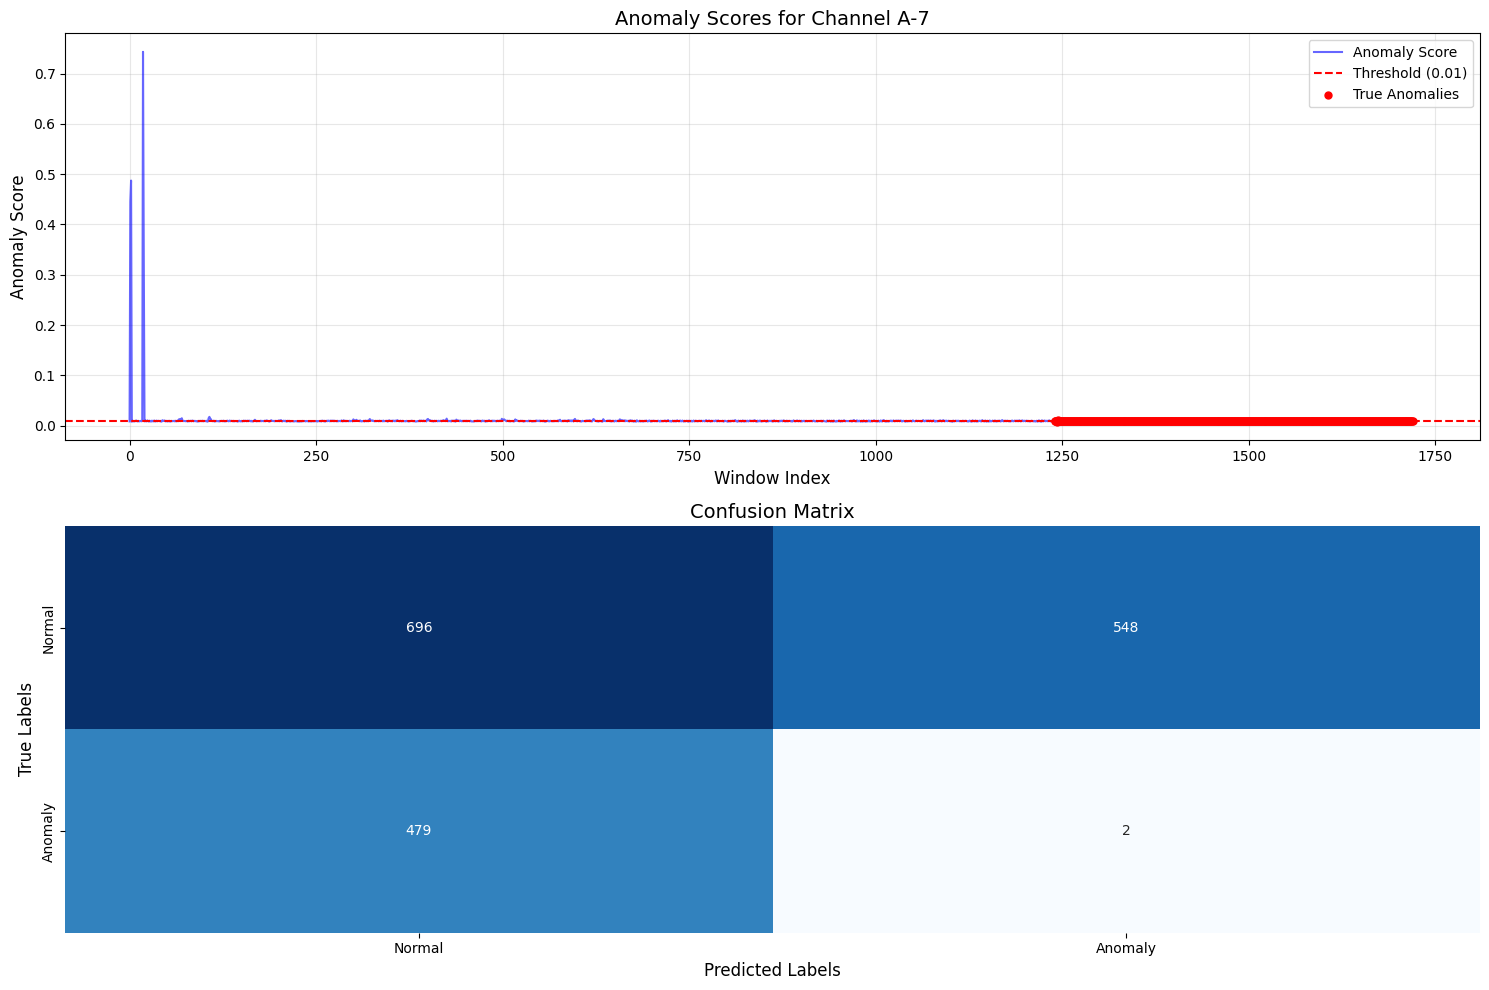


Metrics for channel A-7:
Accuracy: 0.4046
Precision: 0.0036
Recall: 0.0042
F1-Score: 0.0039

Processing channel: A-8

Channel A-8:
Train windows shape: (151, 10, 25)
Test windows shape: (1674, 10, 25)
Anomaly windows: 761/1674
Anomaly class: [contextual]
Epoch 1, Train Loss: 4.0871, Val Loss: 3.0570
Train MSE: 1.024163, Discrepancy: 30.629483
Epoch 2, Train Loss: 3.1531, Val Loss: 2.3413
Train MSE: 0.437785, Discrepancy: 27.153400
Epoch 3, Train Loss: 2.0477, Val Loss: 1.0960
Train MSE: 0.386037, Discrepancy: 16.617051
Epoch 4, Train Loss: 1.2325, Val Loss: 0.8721
Train MSE: 0.323023, Discrepancy: 9.094415
Epoch 5, Train Loss: 0.9173, Val Loss: 0.5587
Train MSE: 0.274196, Discrepancy: 6.431353
Epoch 6, Train Loss: 0.7154, Val Loss: 0.5073
Train MSE: 0.248649, Discrepancy: 4.667388
Epoch 7, Train Loss: 0.6725, Val Loss: 0.4133
Train MSE: 0.265834, Discrepancy: 4.066267
Epoch 8, Train Loss: 0.5749, Val Loss: 0.3730
Train MSE: 0.230620, Discrepancy: 3.443213
Epoch 9, Train Loss: 0.5324, 

Computing threshold: 100%|██████████| 4/4 [00:00<00:00, 88.59it/s]



Computed threshold: 0.0137


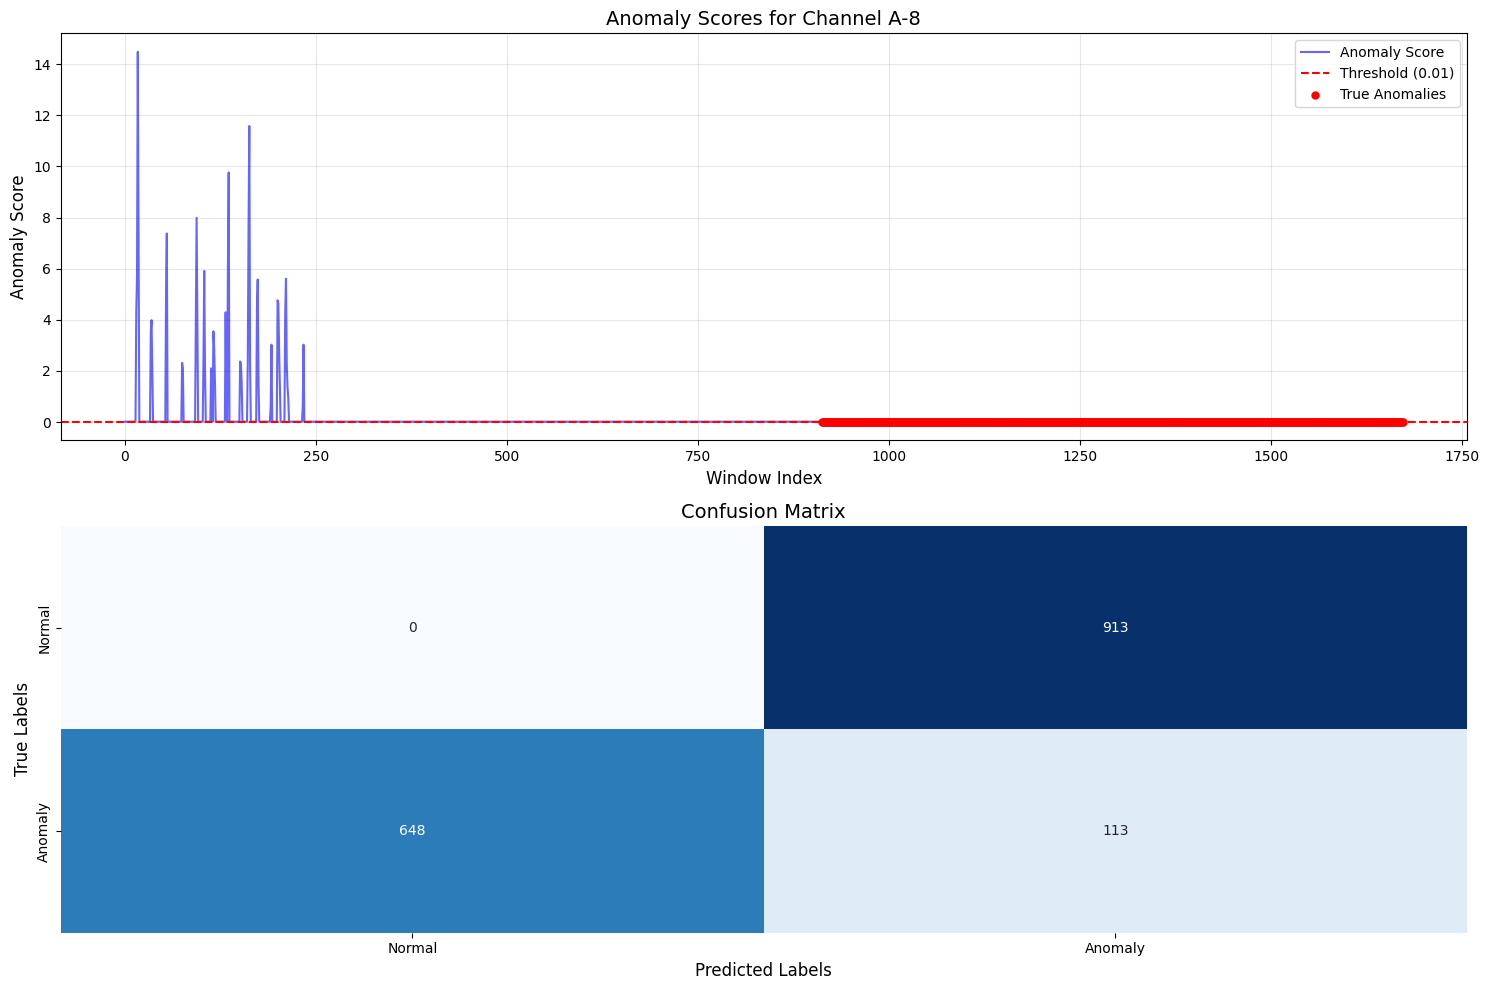


Metrics for channel A-8:
Accuracy: 0.0675
Precision: 0.1101
Recall: 0.1485
F1-Score: 0.1265

Processing channel: A-9

Channel A-9:
Train windows shape: (151, 10, 25)
Test windows shape: (1685, 10, 25)
Anomaly windows: 772/1685
Anomaly class: [contextual]
Epoch 1, Train Loss: 4.1246, Val Loss: 3.1249
Train MSE: 1.049787, Discrepancy: 30.748356
Epoch 2, Train Loss: 3.2053, Val Loss: 2.5139
Train MSE: 0.442761, Discrepancy: 27.625854
Epoch 3, Train Loss: 2.1896, Val Loss: 1.1623
Train MSE: 0.378393, Discrepancy: 18.111695
Epoch 4, Train Loss: 1.2623, Val Loss: 0.9080
Train MSE: 0.331188, Discrepancy: 9.311007
Epoch 5, Train Loss: 0.9687, Val Loss: 0.5801
Train MSE: 0.275850, Discrepancy: 6.928404
Epoch 6, Train Loss: 0.7282, Val Loss: 0.5220
Train MSE: 0.251573, Discrepancy: 4.766014
Epoch 7, Train Loss: 0.6450, Val Loss: 0.4276
Train MSE: 0.223716, Discrepancy: 4.213233
Epoch 8, Train Loss: 0.5687, Val Loss: 0.3905
Train MSE: 0.215840, Discrepancy: 3.528613
Epoch 9, Train Loss: 0.5250, 

Computing threshold: 100%|██████████| 4/4 [00:00<00:00, 73.36it/s]


Computed threshold: 0.0132


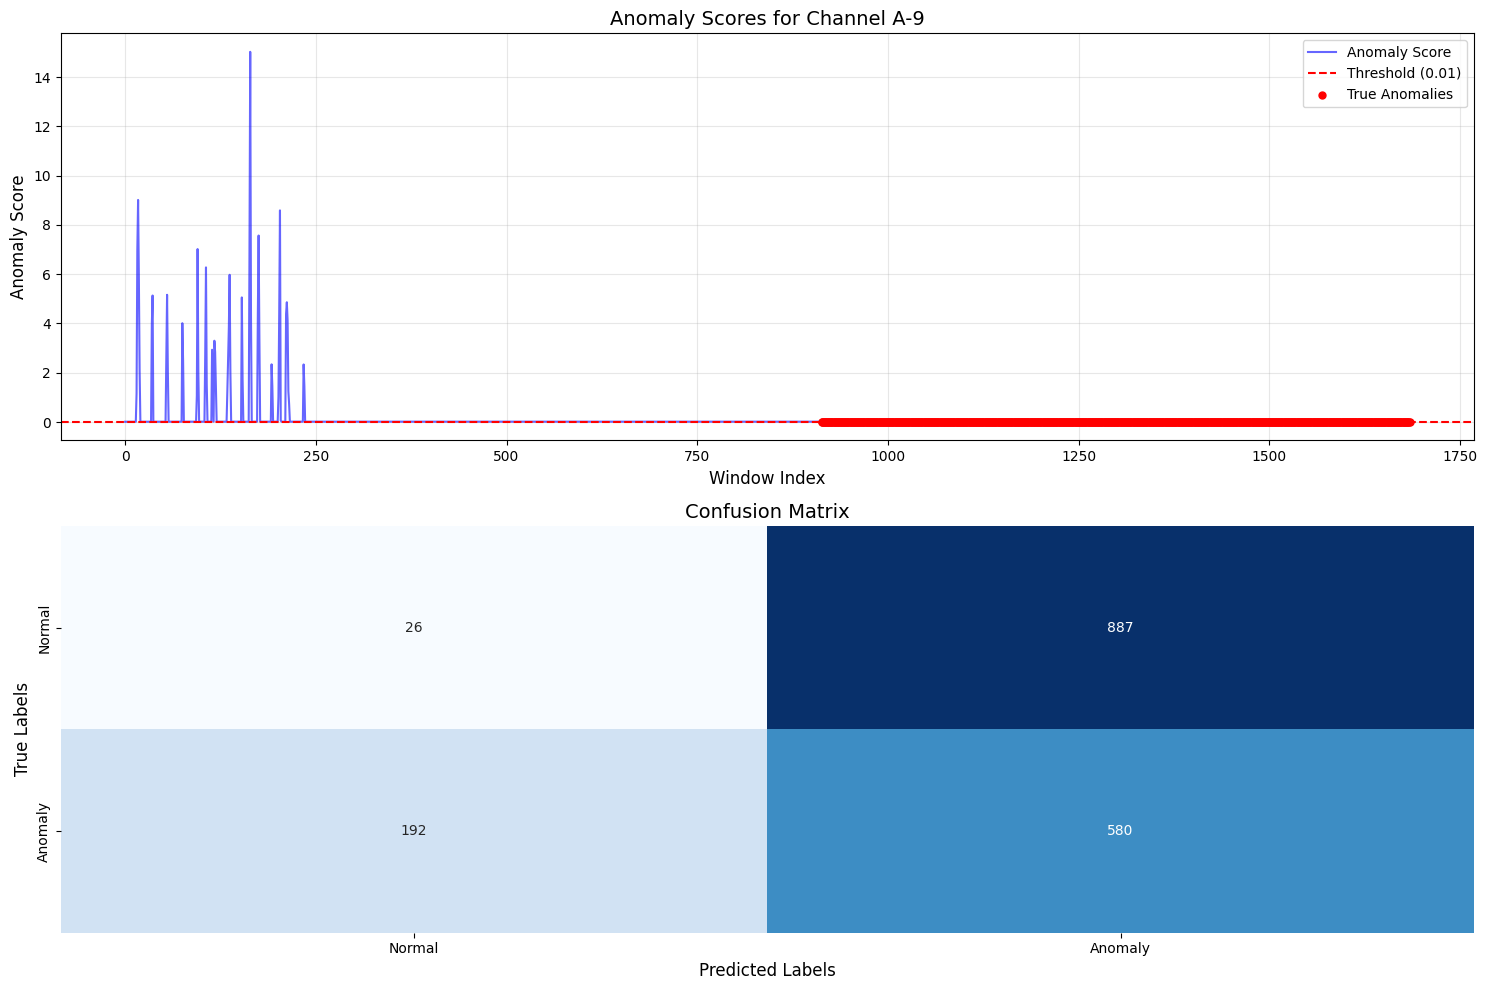


Metrics for channel A-9:
Accuracy: 0.3596
Precision: 0.3954
Recall: 0.7513
F1-Score: 0.5181

Processing channel: B-1

Channel B-1:
Train windows shape: (486, 10, 25)
Test windows shape: (1607, 10, 25)
Anomaly windows: 15/1607
Anomaly class: [point]

⚠️ WARNING: Skipping channel B-1 Insufficient anomaly windows

Processing channel: C-1

Channel C-1:
Train windows shape: (430, 10, 55)
Test windows shape: (451, 10, 55)
Anomaly windows: 64/451
Anomaly class: [point, contextual]

⚠️ WARNING: Skipping channel C-1 Insufficient anomaly windows

Processing channel: C-2

Channel C-2:
Train windows shape: (151, 10, 55)
Test windows shape: (409, 10, 55)
Anomaly windows: 29/409
Anomaly class: [point, contextual]

⚠️ WARNING: Skipping channel C-2 Insufficient anomaly windows

Processing channel: D-1

Channel D-1:
Train windows shape: (568, 10, 25)
Test windows shape: (1700, 10, 25)
Anomaly windows: 650/1700
Anomaly class: [point]
Epoch 1, Train Loss: 2.7912, Val Loss: 1.4108
Train MSE: 0.573006, Di

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 85.98it/s]



Computed threshold: 0.0073


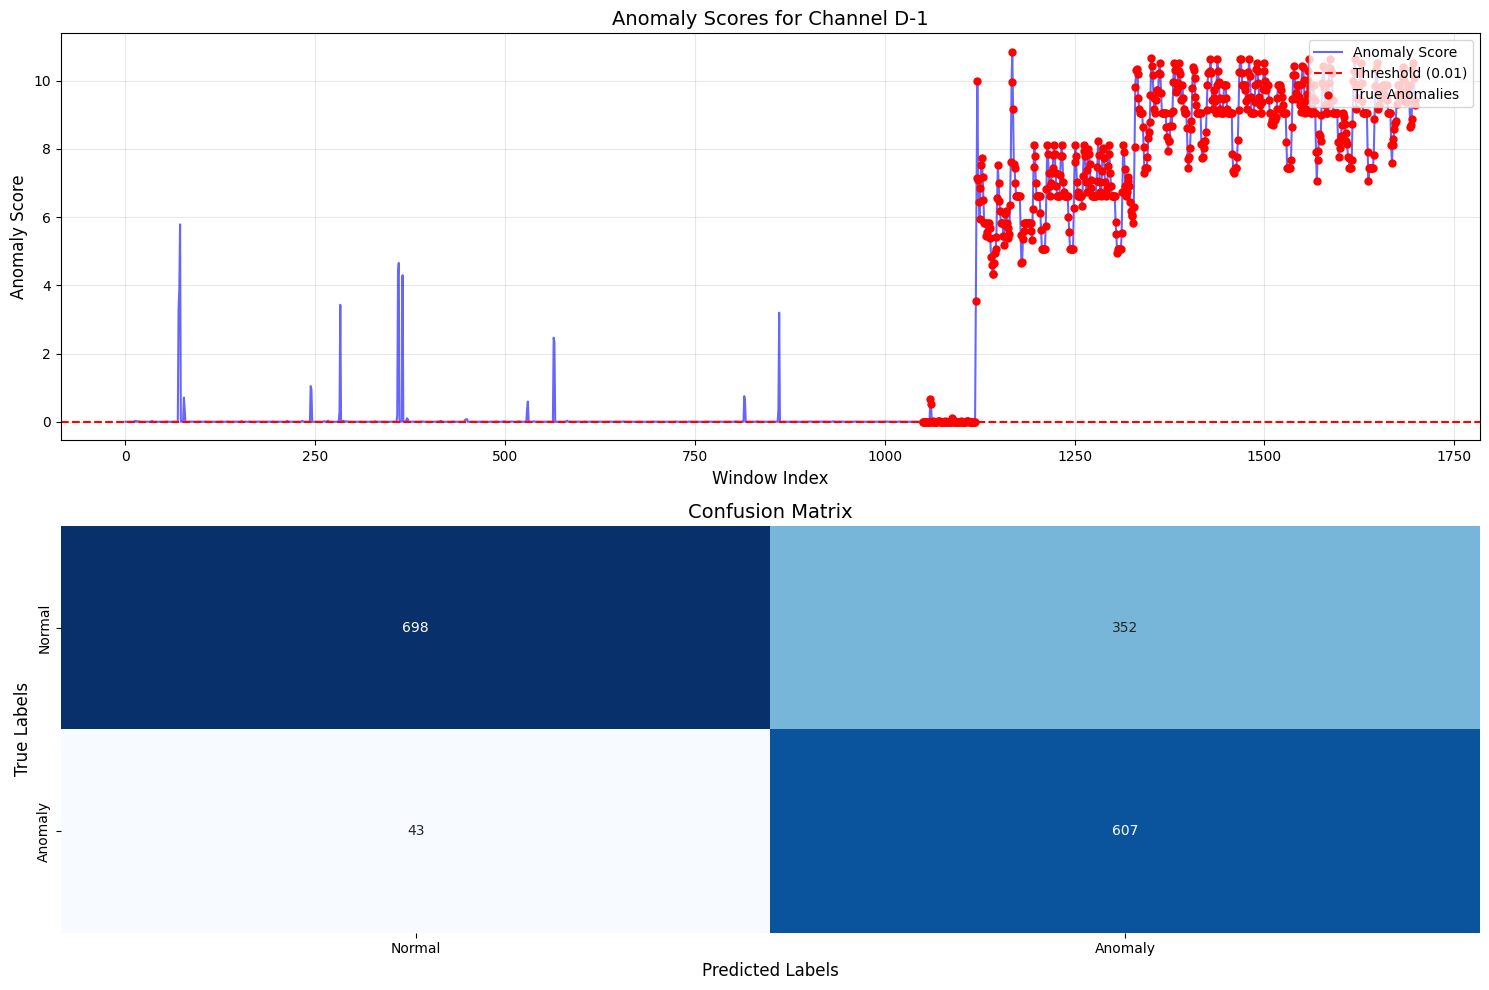


Metrics for channel D-1:
Accuracy: 0.7676
Precision: 0.6330
Recall: 0.9338
F1-Score: 0.7545

Processing channel: D-11

Channel D-11:
Train windows shape: (521, 10, 25)
Test windows shape: (1485, 10, 25)
Anomaly windows: 13/1485
Anomaly class: [point]

⚠️ WARNING: Skipping channel D-11 Insufficient anomaly windows

Processing channel: D-12

Channel D-12:
Train windows shape: (61, 10, 25)
Test windows shape: (1582, 10, 25)
Anomaly windows: 547/1582
Anomaly class: [point]
Epoch 1, Train Loss: 3.9354, Val Loss: 3.7491
Train MSE: 0.775032, Discrepancy: 31.603194
Epoch 2, Train Loss: 3.4596, Val Loss: 2.9124
Train MSE: 0.460646, Discrepancy: 29.989347
Epoch 3, Train Loss: 2.9242, Val Loss: 2.7936
Train MSE: 0.056780, Discrepancy: 28.674505
Epoch 4, Train Loss: 2.7362, Val Loss: 2.2955
Train MSE: 0.106792, Discrepancy: 26.293758
Epoch 5, Train Loss: 2.1724, Val Loss: 1.4977
Train MSE: 0.035457, Discrepancy: 21.369362
Epoch 6, Train Loss: 1.3942, Val Loss: 0.9544
Train MSE: 0.037314, Discrepa

Computing threshold: 100%|██████████| 2/2 [00:00<00:00, 68.88it/s]



Computed threshold: 0.0262


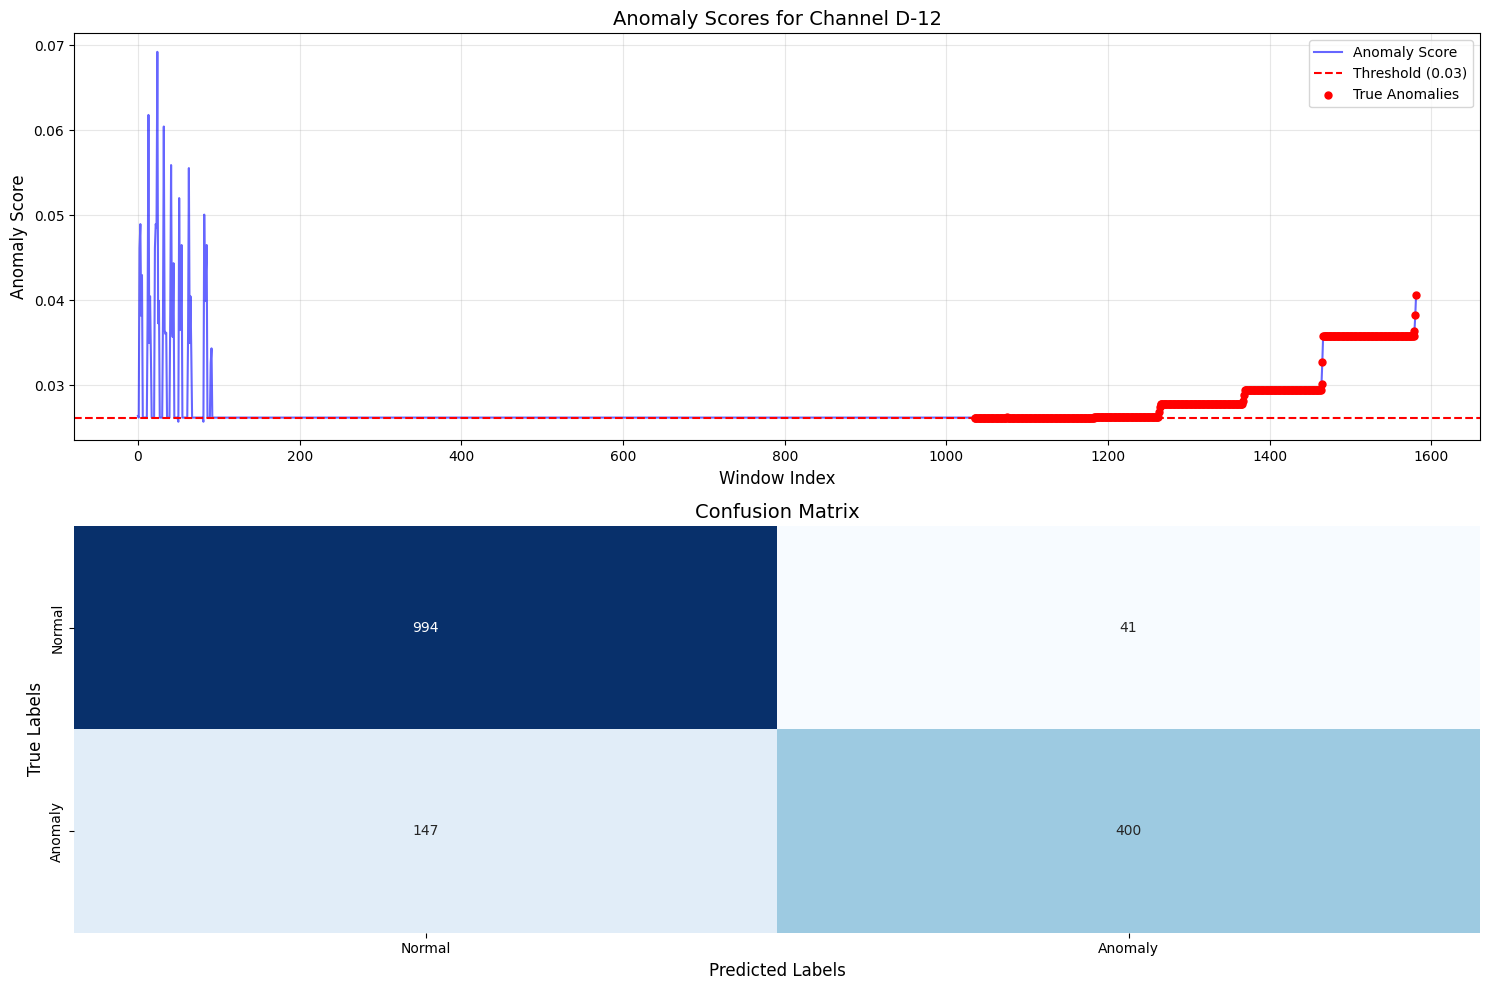


Metrics for channel D-12:
Accuracy: 0.8812
Precision: 0.9070
Recall: 0.7313
F1-Score: 0.8097

Processing channel: D-13

Channel D-13:
Train windows shape: (297, 10, 25)
Test windows shape: (1531, 10, 25)
Anomaly windows: 33/1531
Anomaly class: [point]

⚠️ WARNING: Skipping channel D-13 Insufficient anomaly windows

Processing channel: D-14

Channel D-14:
Train windows shape: (734, 10, 55)
Test windows shape: (524, 10, 55)
Anomaly windows: 46/524
Anomaly class: [point, point]

⚠️ WARNING: Skipping channel D-14 Insufficient anomaly windows

Processing channel: D-15

Channel D-15:
Train windows shape: (413, 10, 55)
Test windows shape: (430, 10, 55)
Anomaly windows: 129/430
Anomaly class: [point]
Epoch 1, Train Loss: 2.8000, Val Loss: 1.0964
Train MSE: 0.379906, Discrepancy: 24.200817
Epoch 2, Train Loss: 0.8908, Val Loss: 0.5064
Train MSE: 0.196549, Discrepancy: 6.942429
Epoch 3, Train Loss: 0.4956, Val Loss: 0.3229
Train MSE: 0.129191, Discrepancy: 3.664044
Epoch 4, Train Loss: 0.3534, 

Computing threshold: 100%|██████████| 11/11 [00:00<00:00, 77.28it/s]


Computed threshold: 0.0076


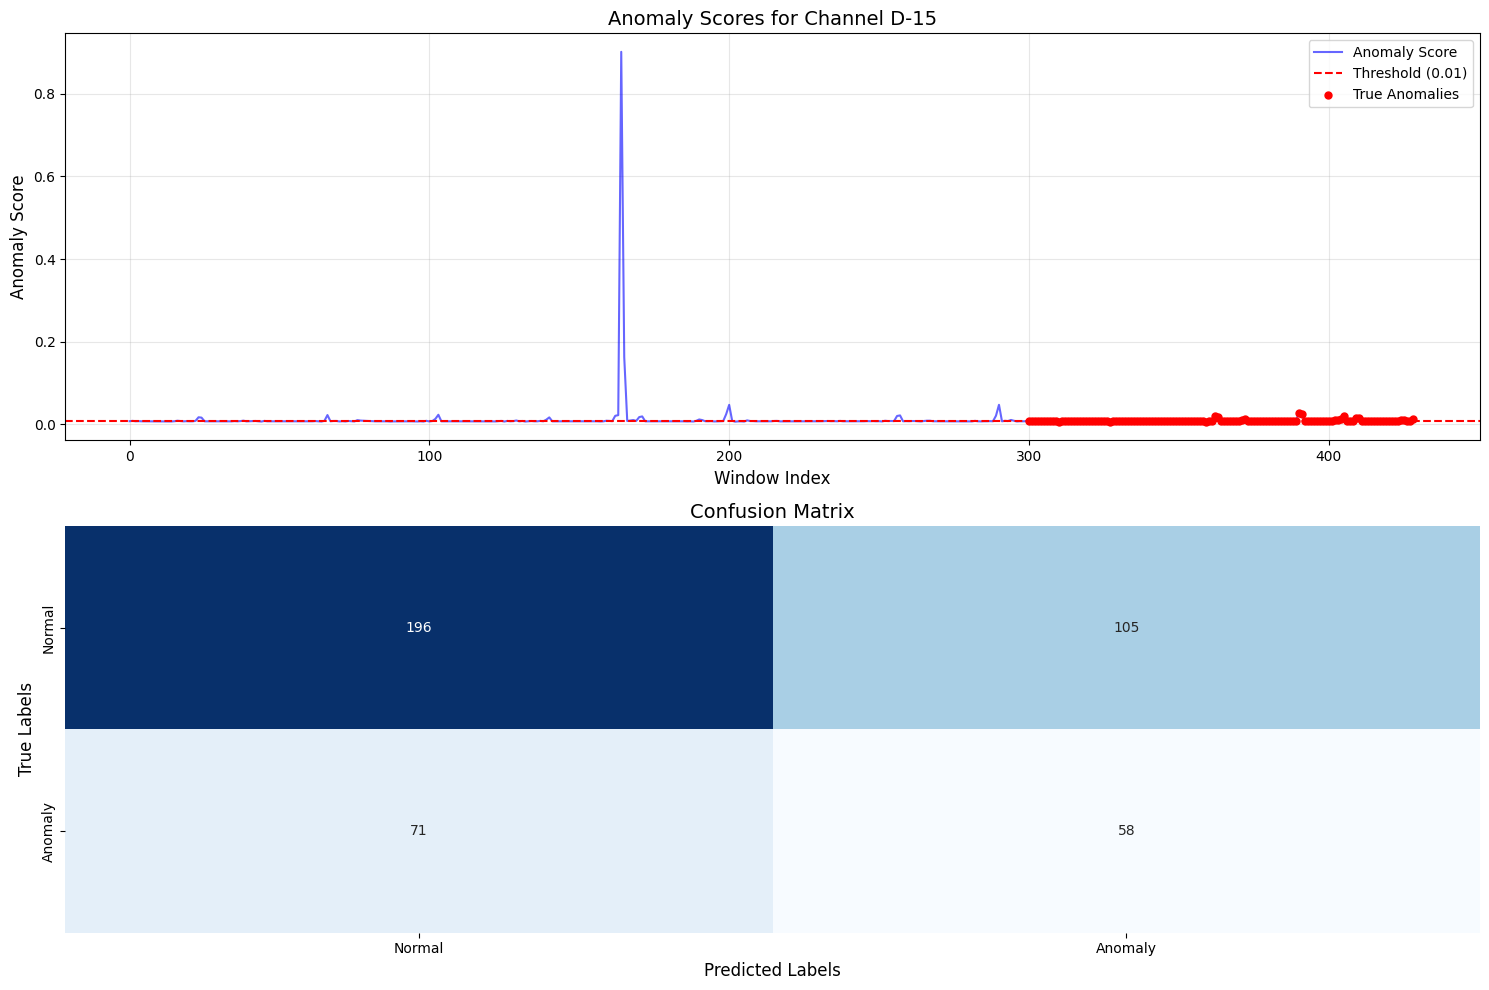


Metrics for channel D-15:
Accuracy: 0.5907
Precision: 0.3558
Recall: 0.4496
F1-Score: 0.3973

Processing channel: D-16

Channel D-16:
Train windows shape: (289, 10, 55)
Test windows shape: (437, 10, 55)
Anomaly windows: 131/437
Anomaly class: [contextual]
Epoch 1, Train Loss: 3.2669, Val Loss: 2.0687
Train MSE: 0.425042, Discrepancy: 28.418875
Epoch 2, Train Loss: 1.3876, Val Loss: 0.8392
Train MSE: 0.233077, Discrepancy: 11.544753
Epoch 3, Train Loss: 0.7257, Val Loss: 0.4933
Train MSE: 0.187346, Discrepancy: 5.383518
Epoch 4, Train Loss: 0.4839, Val Loss: 0.3514
Train MSE: 0.126685, Discrepancy: 3.572174
Epoch 5, Train Loss: 0.4018, Val Loss: 0.2863
Train MSE: 0.119316, Discrepancy: 2.824510
Epoch 6, Train Loss: 0.3021, Val Loss: 0.2186
Train MSE: 0.082110, Discrepancy: 2.199741
Epoch 7, Train Loss: 0.2360, Val Loss: 0.1657
Train MSE: 0.070390, Discrepancy: 1.656070
Epoch 8, Train Loss: 0.1882, Val Loss: 0.1308
Train MSE: 0.062164, Discrepancy: 1.260352
Epoch 9, Train Loss: 0.1561, 

Computing threshold: 100%|██████████| 8/8 [00:00<00:00, 63.19it/s]


Computed threshold: 0.0088


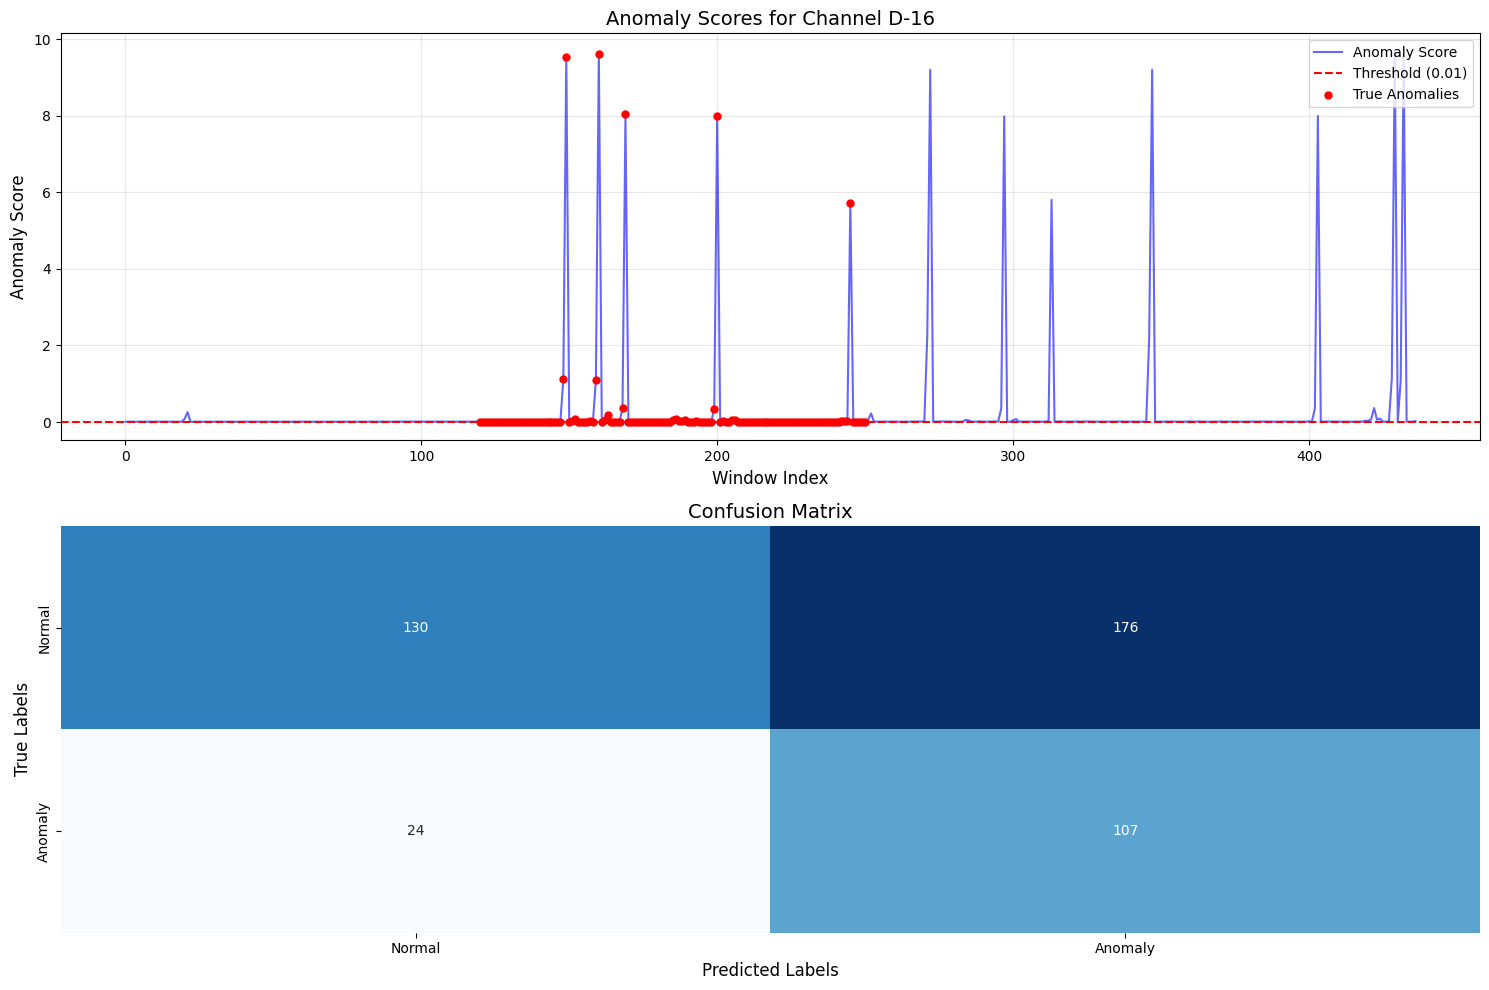


Metrics for channel D-16:
Accuracy: 0.5423
Precision: 0.3781
Recall: 0.8168
F1-Score: 0.5169

Processing channel: D-2

Channel D-2:
Train windows shape: (575, 10, 25)
Test windows shape: (1718, 10, 25)
Anomaly windows: 845/1718
Anomaly class: [point]
Epoch 1, Train Loss: 2.7468, Val Loss: 1.7363
Train MSE: 0.588691, Discrepancy: 21.581217
Epoch 2, Train Loss: 0.8222, Val Loss: 1.1037
Train MSE: 0.269120, Discrepancy: 5.531181
Epoch 3, Train Loss: 0.4860, Val Loss: 0.9207
Train MSE: 0.183839, Discrepancy: 3.021637
Epoch 4, Train Loss: 0.3956, Val Loss: 0.8023
Train MSE: 0.190990, Discrepancy: 2.046278
Epoch 5, Train Loss: 0.2721, Val Loss: 0.7311
Train MSE: 0.142084, Discrepancy: 1.299793
Epoch 6, Train Loss: 0.2685, Val Loss: 0.6906
Train MSE: 0.177000, Discrepancy: 0.915364
Epoch 7, Train Loss: 0.1952, Val Loss: 0.6612
Train MSE: 0.126072, Discrepancy: 0.691505
Epoch 8, Train Loss: 0.2209, Val Loss: 0.6442
Train MSE: 0.164017, Discrepancy: 0.568793
Epoch 9, Train Loss: 0.1641, Val Lo

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 72.34it/s]



Computed threshold: 0.0082


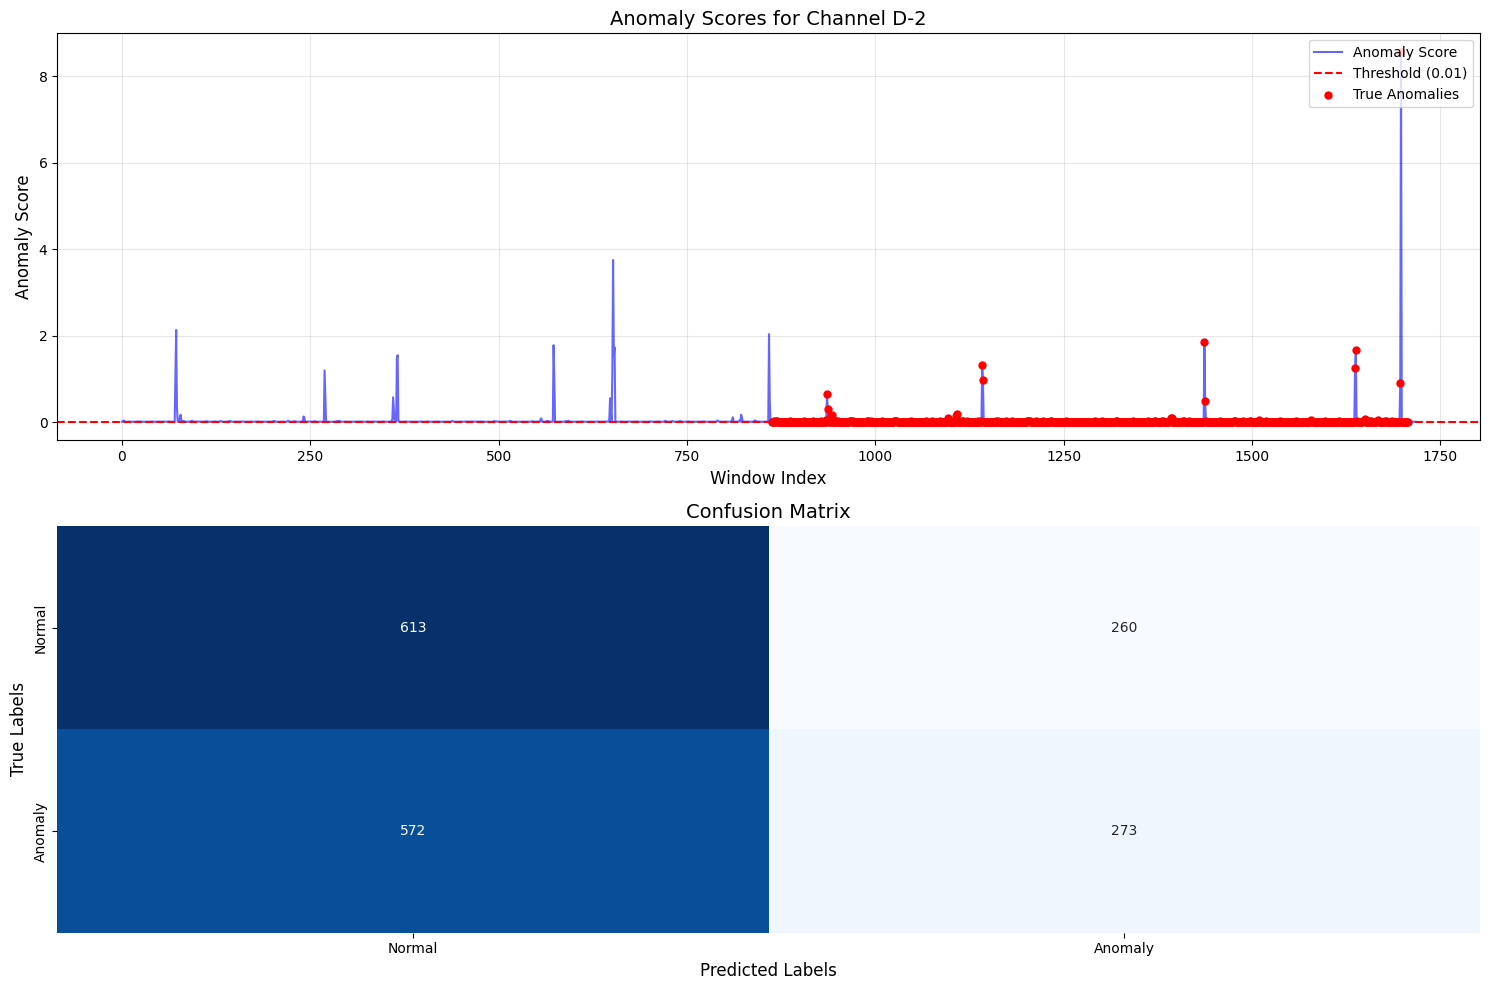


Metrics for channel D-2:
Accuracy: 0.5157
Precision: 0.5122
Recall: 0.3231
F1-Score: 0.3962

Processing channel: D-3

Channel D-3:
Train windows shape: (575, 10, 25)
Test windows shape: (1727, 10, 25)
Anomaly windows: 656/1727
Anomaly class: [point]
Epoch 1, Train Loss: 2.9189, Val Loss: 1.1623
Train MSE: 0.713618, Discrepancy: 22.053303
Epoch 2, Train Loss: 0.9439, Val Loss: 0.5233
Train MSE: 0.358537, Discrepancy: 5.853131
Epoch 3, Train Loss: 0.5797, Val Loss: 0.3793
Train MSE: 0.257525, Discrepancy: 3.221939
Epoch 4, Train Loss: 0.4580, Val Loss: 0.2743
Train MSE: 0.233906, Discrepancy: 2.240778
Epoch 5, Train Loss: 0.3472, Val Loss: 0.2034
Train MSE: 0.200006, Discrepancy: 1.471539
Epoch 6, Train Loss: 0.2981, Val Loss: 0.1675
Train MSE: 0.195171, Discrepancy: 1.029248
Epoch 7, Train Loss: 0.2579, Val Loss: 0.1421
Train MSE: 0.179715, Discrepancy: 0.782170
Epoch 8, Train Loss: 0.2428, Val Loss: 0.1255
Train MSE: 0.178848, Discrepancy: 0.639757
Epoch 9, Train Loss: 0.2166, Val Los

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 88.01it/s]


Computed threshold: 0.0076


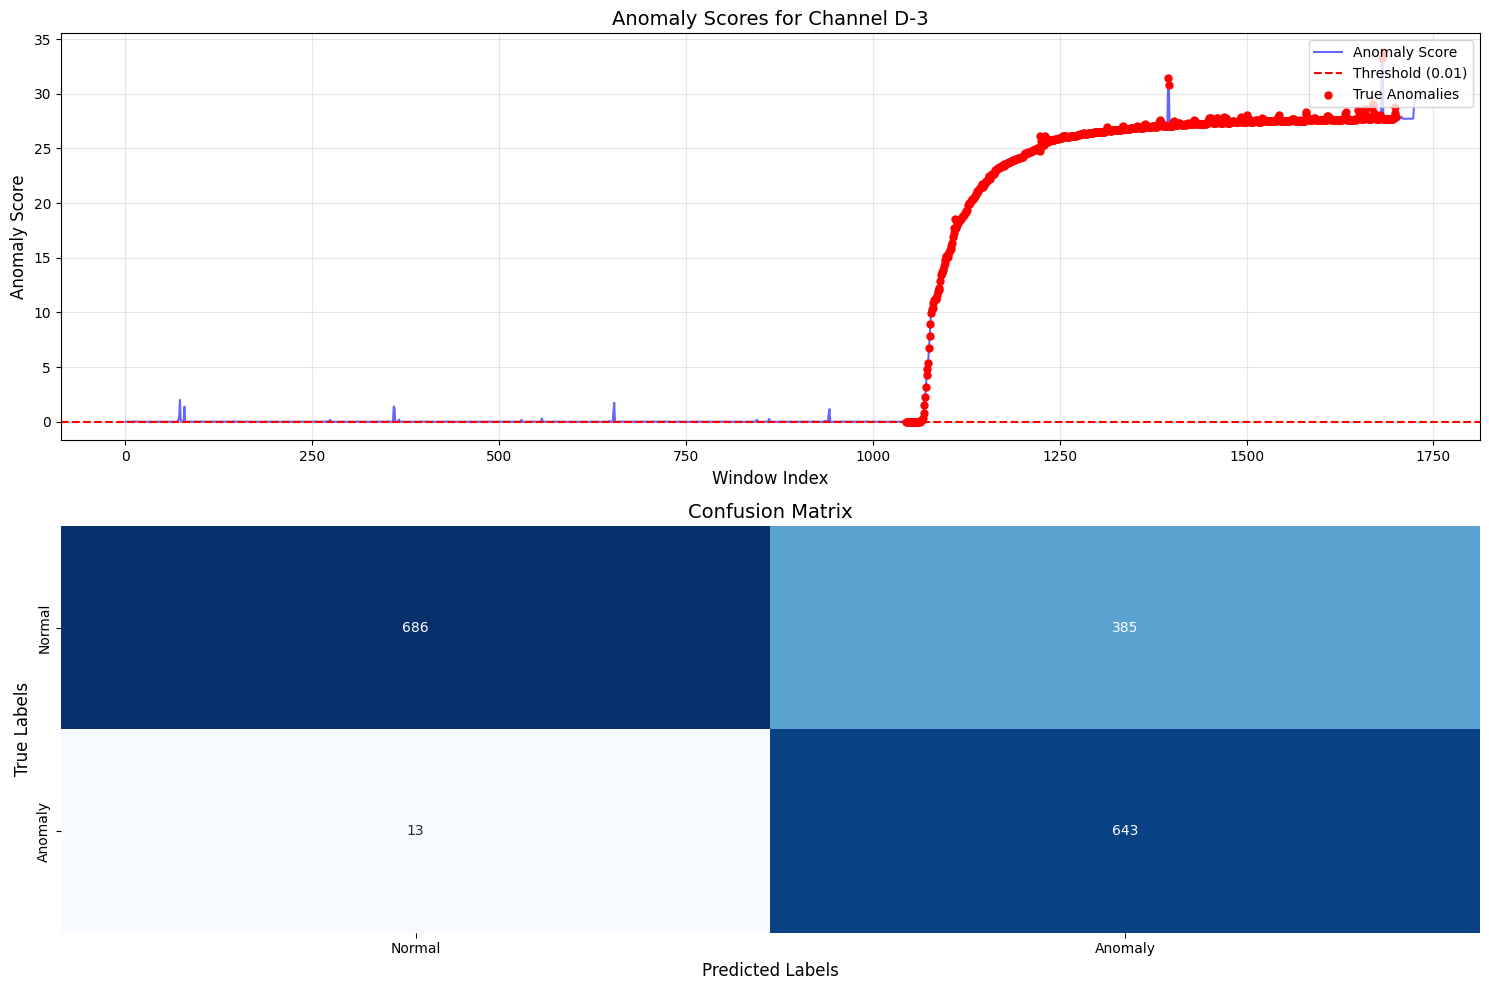


Metrics for channel D-3:
Accuracy: 0.7695
Precision: 0.6255
Recall: 0.9802
F1-Score: 0.7637

Processing channel: D-4

Channel D-4:
Train windows shape: (565, 10, 25)
Test windows shape: (1693, 10, 25)
Anomaly windows: 648/1693
Anomaly class: [point]
Epoch 1, Train Loss: 2.9196, Val Loss: 1.0722
Train MSE: 0.729584, Discrepancy: 21.900661
Epoch 2, Train Loss: 0.9186, Val Loss: 0.4703
Train MSE: 0.343904, Discrepancy: 5.747029
Epoch 3, Train Loss: 0.5793, Val Loss: 0.3303
Train MSE: 0.260401, Discrepancy: 3.188790
Epoch 4, Train Loss: 0.4466, Val Loss: 0.2262
Train MSE: 0.224396, Discrepancy: 2.221923
Epoch 5, Train Loss: 0.3507, Val Loss: 0.1615
Train MSE: 0.203209, Discrepancy: 1.475393
Epoch 6, Train Loss: 0.2935, Val Loss: 0.1259
Train MSE: 0.191271, Discrepancy: 1.021873
Epoch 7, Train Loss: 0.2586, Val Loss: 0.1050
Train MSE: 0.180135, Discrepancy: 0.785098
Epoch 8, Train Loss: 0.2369, Val Loss: 0.0901
Train MSE: 0.173461, Discrepancy: 0.634147
Epoch 9, Train Loss: 0.2182, Val Los

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 49.21it/s]



Computed threshold: 0.0085


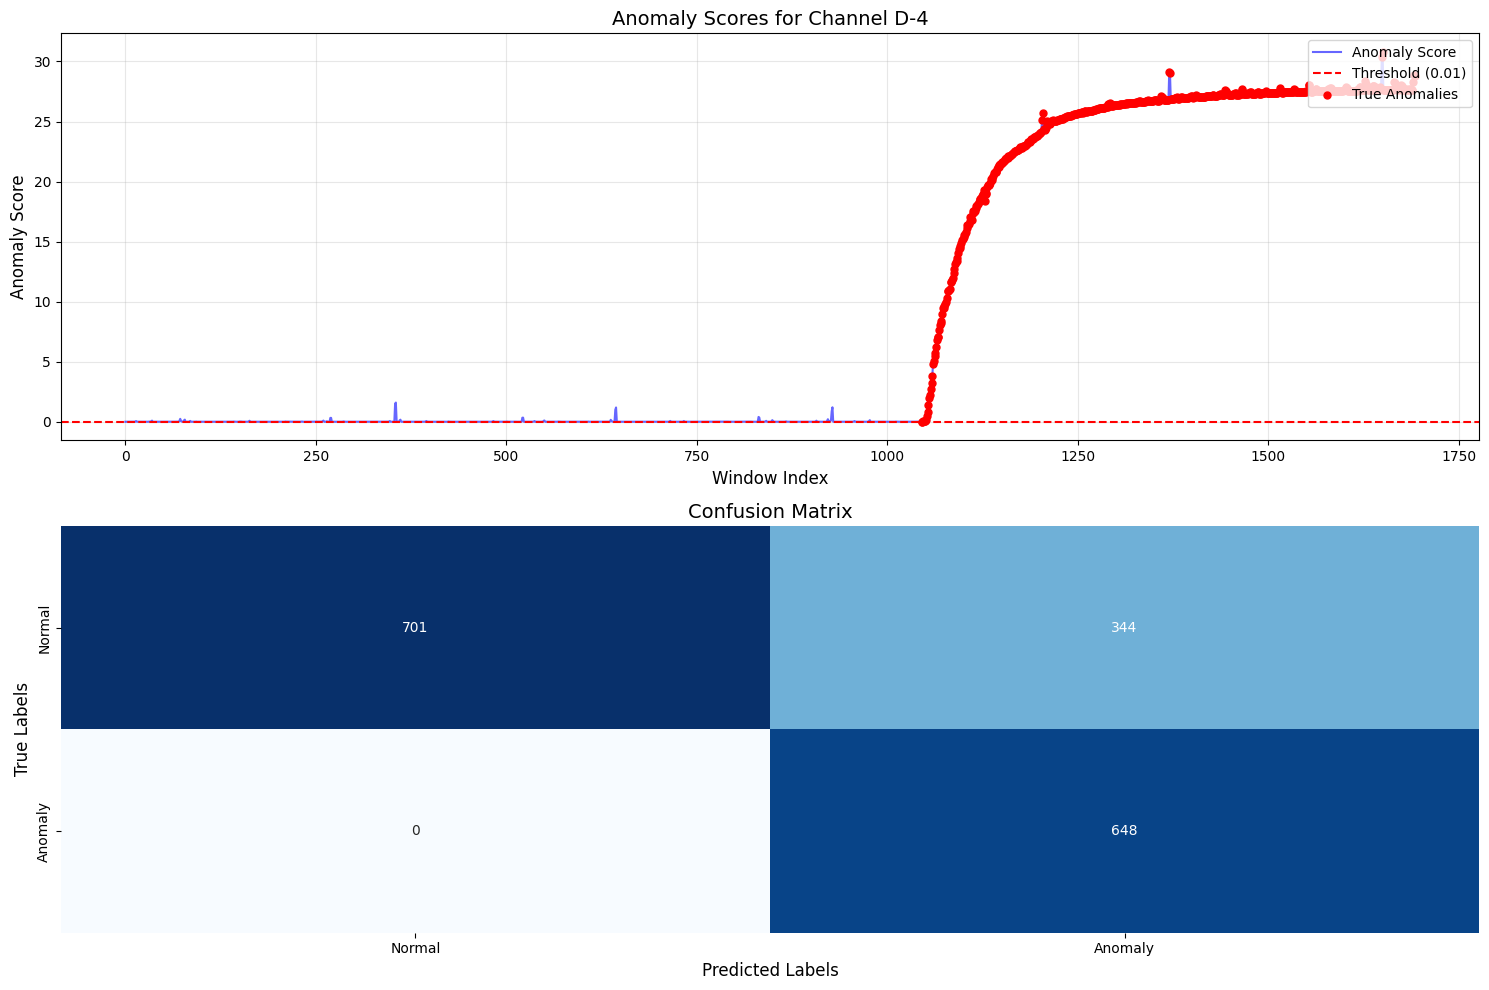


Metrics for channel D-4:
Accuracy: 0.7968
Precision: 0.6532
Recall: 1.0000
F1-Score: 0.7902

Processing channel: D-5

Channel D-5:
Train windows shape: (511, 10, 25)
Test windows shape: (1524, 10, 25)
Anomaly windows: 11/1524
Anomaly class: [point]

⚠️ WARNING: Skipping channel D-5 Insufficient anomaly windows

Processing channel: D-6

Channel D-6:
Train windows shape: (517, 10, 25)
Test windows shape: (1575, 10, 25)
Anomaly windows: 17/1575
Anomaly class: [point]

⚠️ WARNING: Skipping channel D-6 Insufficient anomaly windows

Processing channel: D-7

Channel D-7:
Train windows shape: (515, 10, 25)
Test windows shape: (1527, 10, 25)
Anomaly windows: 539/1527
Anomaly class: [point]
Epoch 1, Train Loss: 3.1642, Val Loss: 1.7341
Train MSE: 0.714723, Discrepancy: 24.494638
Epoch 2, Train Loss: 1.0184, Val Loss: 1.0766
Train MSE: 0.321035, Discrepancy: 6.974024
Epoch 3, Train Loss: 0.6111, Val Loss: 0.8344
Train MSE: 0.243076, Discrepancy: 3.679828
Epoch 4, Train Loss: 0.4678, Val Loss: 0.

Computing threshold: 100%|██████████| 13/13 [00:00<00:00, 77.14it/s]


Computed threshold: 0.0078


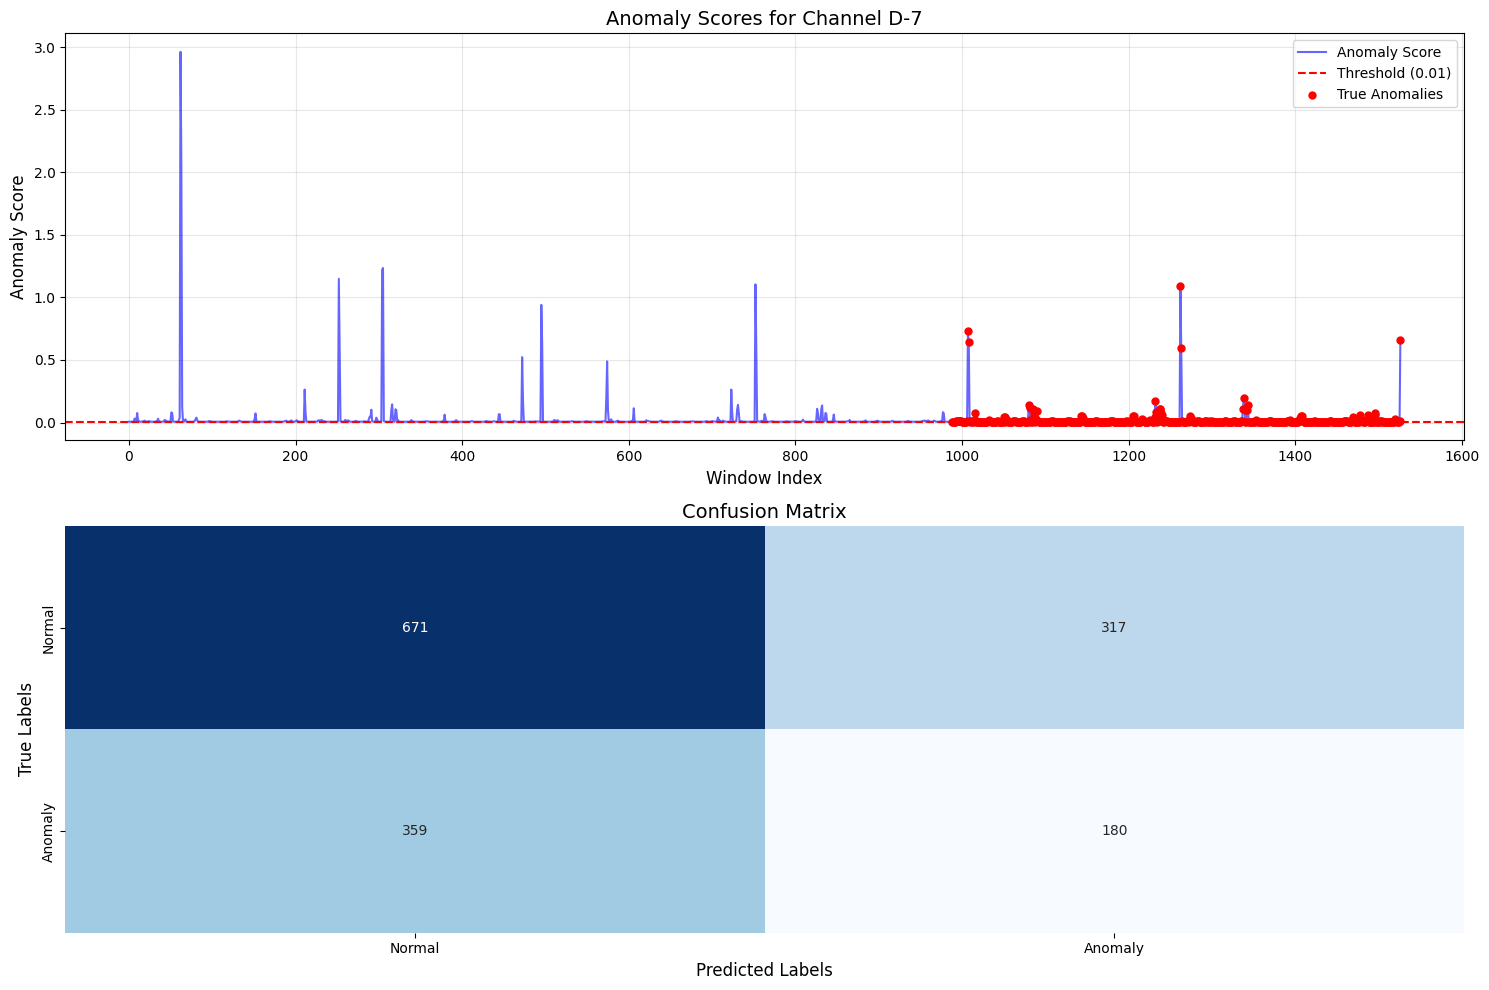


Metrics for channel D-7:
Accuracy: 0.5573
Precision: 0.3622
Recall: 0.3340
F1-Score: 0.3475

Processing channel: D-8

Channel D-8:
Train windows shape: (519, 10, 25)
Test windows shape: (1573, 10, 25)
Anomaly windows: 11/1573
Anomaly class: [point]

⚠️ WARNING: Skipping channel D-8 Insufficient anomaly windows

Processing channel: D-9

Channel D-9:
Train windows shape: (515, 10, 25)
Test windows shape: (1480, 10, 25)
Anomaly windows: 230/1480
Anomaly class: [point]
Epoch 1, Train Loss: 2.8587, Val Loss: 2.3338
Train MSE: 0.498563, Discrepancy: 23.601109
Epoch 2, Train Loss: 0.8299, Val Loss: 1.6192
Train MSE: 0.205017, Discrepancy: 6.248444
Epoch 3, Train Loss: 0.4853, Val Loss: 1.3809
Train MSE: 0.152442, Discrepancy: 3.328509
Epoch 4, Train Loss: 0.3693, Val Loss: 1.2246
Train MSE: 0.125822, Discrepancy: 2.435104
Epoch 5, Train Loss: 0.2792, Val Loss: 1.1183
Train MSE: 0.108844, Discrepancy: 1.703348
Epoch 6, Train Loss: 0.2181, Val Loss: 1.0644
Train MSE: 0.101031, Discrepancy: 1.1

Computing threshold: 100%|██████████| 13/13 [00:00<00:00, 83.59it/s]


Computed threshold: 0.0054


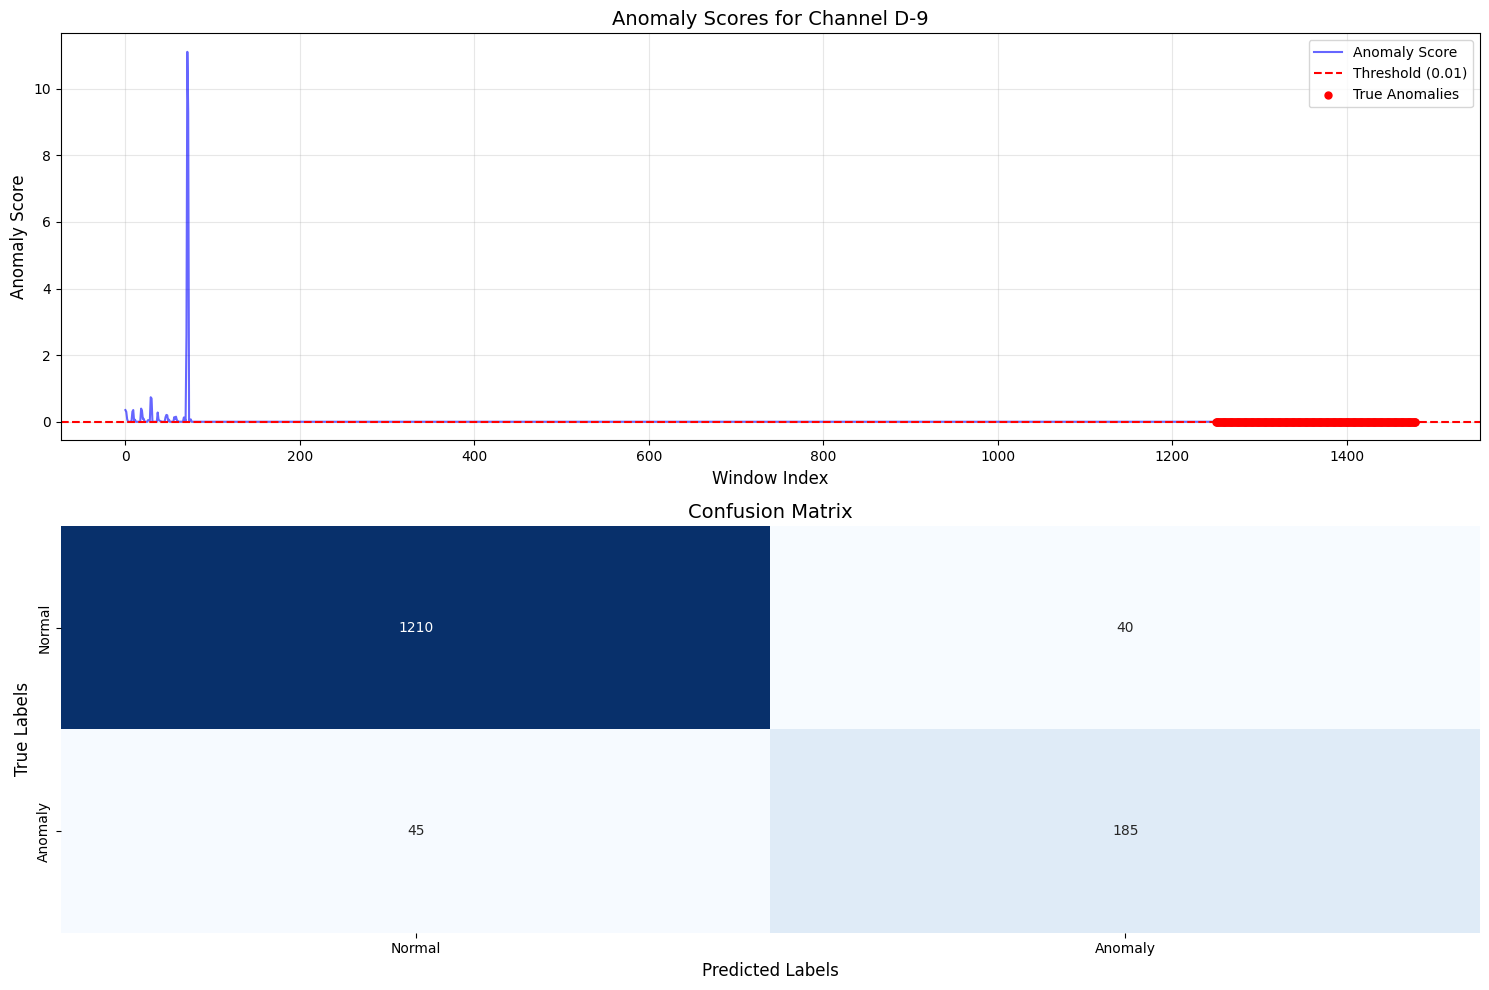


Metrics for channel D-9:
Accuracy: 0.9426
Precision: 0.8222
Recall: 0.8043
F1-Score: 0.8132

Processing channel: E-1

Channel E-1:
Train windows shape: (575, 10, 25)
Test windows shape: (1702, 10, 25)
Anomaly windows: 103/1702
Anomaly class: [contextual, contextual]
Epoch 1, Train Loss: 2.8383, Val Loss: 1.4119
Train MSE: 0.616216, Discrepancy: 22.221239
Epoch 2, Train Loss: 0.7947, Val Loss: 0.7526
Train MSE: 0.243519, Discrepancy: 5.511414
Epoch 3, Train Loss: 0.4932, Val Loss: 0.5717
Train MSE: 0.191122, Discrepancy: 3.020587
Epoch 4, Train Loss: 0.3897, Val Loss: 0.4657
Train MSE: 0.187418, Discrepancy: 2.022408
Epoch 5, Train Loss: 0.2652, Val Loss: 0.3890
Train MSE: 0.134993, Discrepancy: 1.301835
Epoch 6, Train Loss: 0.2182, Val Loss: 0.3564
Train MSE: 0.127270, Discrepancy: 0.909156
Epoch 7, Train Loss: 0.1920, Val Loss: 0.3295
Train MSE: 0.122130, Discrepancy: 0.698465
Epoch 8, Train Loss: 0.1713, Val Loss: 0.3101
Train MSE: 0.115484, Discrepancy: 0.557948
Epoch 9, Train Loss

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 70.07it/s]



Computed threshold: 0.0072


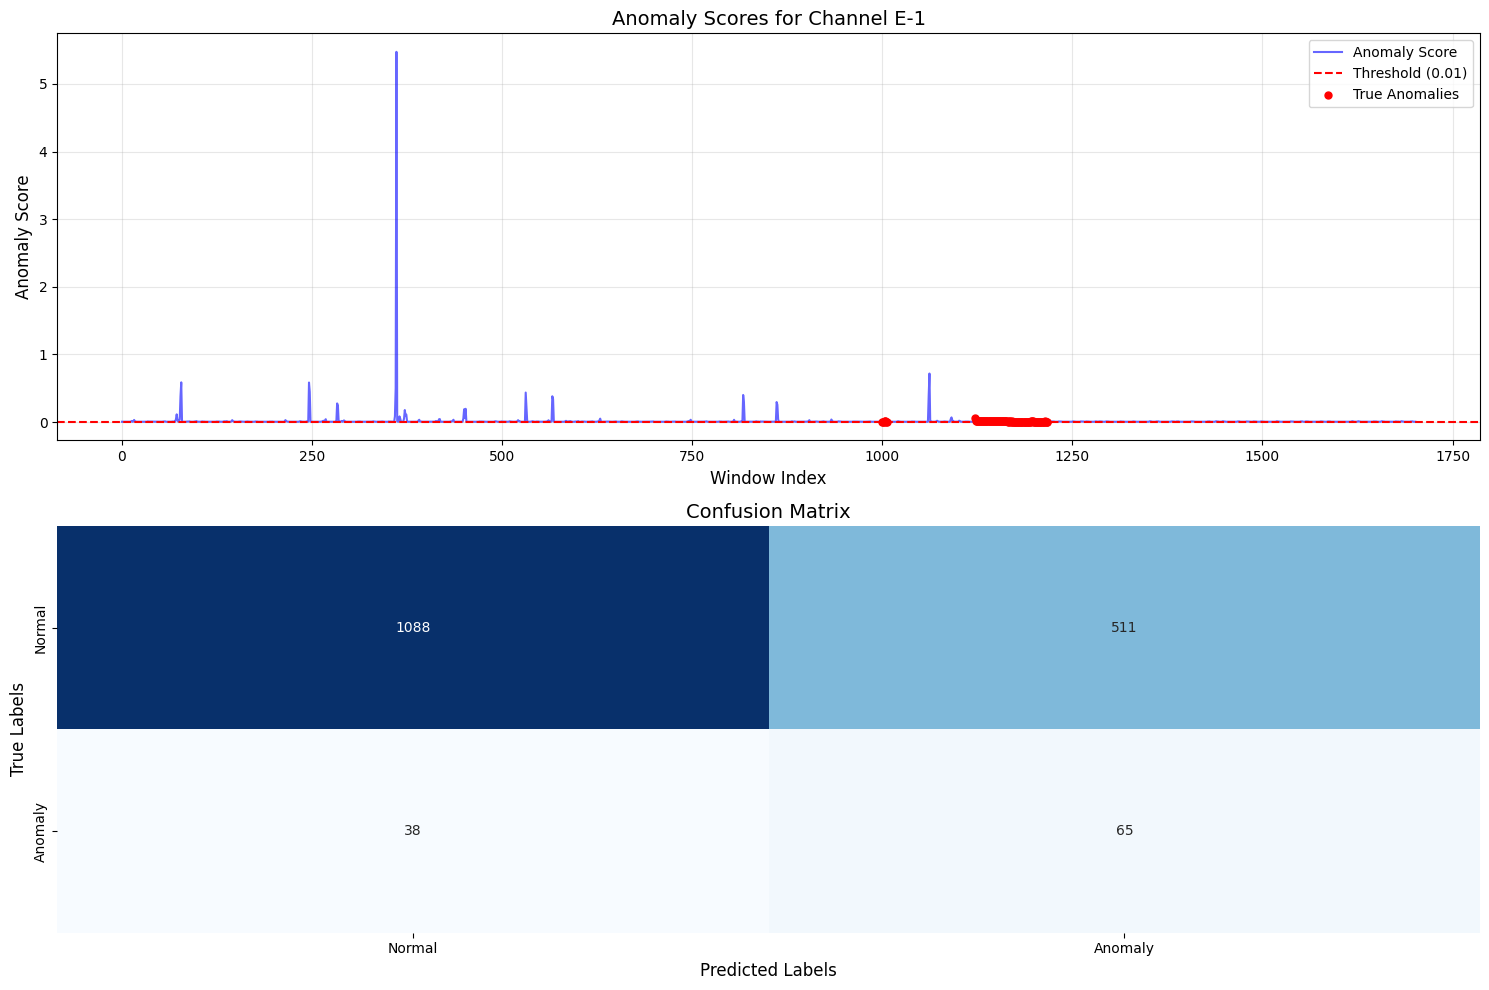


Metrics for channel E-1:
Accuracy: 0.6774
Precision: 0.1128
Recall: 0.6311
F1-Score: 0.1915

Processing channel: E-10

Channel E-10:
Train windows shape: (575, 10, 25)
Test windows shape: (1700, 10, 25)
Anomaly windows: 66/1700
Anomaly class: [contextual, contextual]

⚠️ WARNING: Skipping channel E-10 Insufficient anomaly windows

Processing channel: E-11

Channel E-11:
Train windows shape: (575, 10, 25)
Test windows shape: (1701, 10, 25)
Anomaly windows: 61/1701
Anomaly class: [contextual, contextual]

⚠️ WARNING: Skipping channel E-11 Insufficient anomaly windows

Processing channel: E-12

Channel E-12:
Train windows shape: (575, 10, 25)
Test windows shape: (1701, 10, 25)
Anomaly windows: 118/1701
Anomaly class: [contextual, contextual]
Epoch 1, Train Loss: 2.8885, Val Loss: 1.4107
Train MSE: 0.618956, Discrepancy: 22.695419
Epoch 2, Train Loss: 0.8153, Val Loss: 0.7572
Train MSE: 0.255165, Discrepancy: 5.600863
Epoch 3, Train Loss: 0.4828, Val Loss: 0.5714
Train MSE: 0.184487, Disc

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 27.30it/s]



Computed threshold: 0.0065


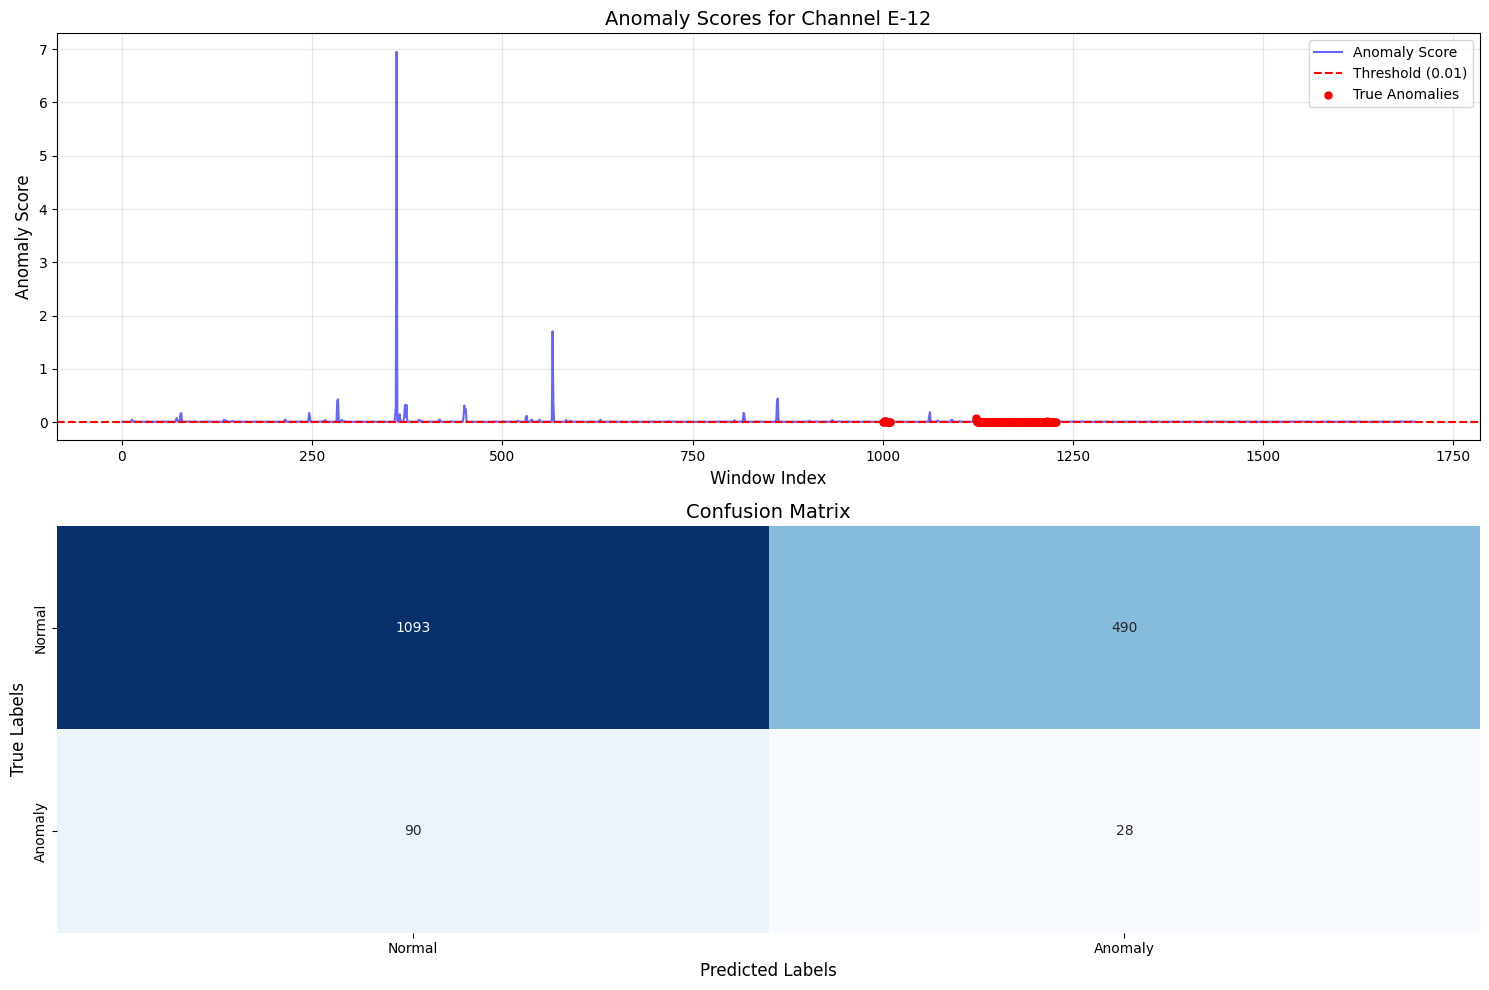


Metrics for channel E-12:
Accuracy: 0.6590
Precision: 0.0541
Recall: 0.2373
F1-Score: 0.0881

Processing channel: E-13

Channel E-13:
Train windows shape: (575, 10, 25)
Test windows shape: (1727, 10, 25)
Anomaly windows: 56/1727
Anomaly class: [contextual, contextual, contextual]

⚠️ WARNING: Skipping channel E-13 Insufficient anomaly windows

Processing channel: E-2

Channel E-2:
Train windows shape: (575, 10, 25)
Test windows shape: (1705, 10, 25)
Anomaly windows: 281/1705
Anomaly class: [point]
Epoch 1, Train Loss: 2.8073, Val Loss: 1.4052
Train MSE: 0.582102, Discrepancy: 22.252183
Epoch 2, Train Loss: 0.8263, Val Loss: 0.7473
Train MSE: 0.259638, Discrepancy: 5.666619
Epoch 3, Train Loss: 0.4984, Val Loss: 0.5798
Train MSE: 0.188511, Discrepancy: 3.099041
Epoch 4, Train Loss: 0.4003, Val Loss: 0.4621
Train MSE: 0.188782, Discrepancy: 2.115141
Epoch 5, Train Loss: 0.2969, Val Loss: 0.3919
Train MSE: 0.158958, Discrepancy: 1.379619
Epoch 6, Train Loss: 0.2340, Val Loss: 0.3553
Trai

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 30.61it/s]



Computed threshold: 0.0072


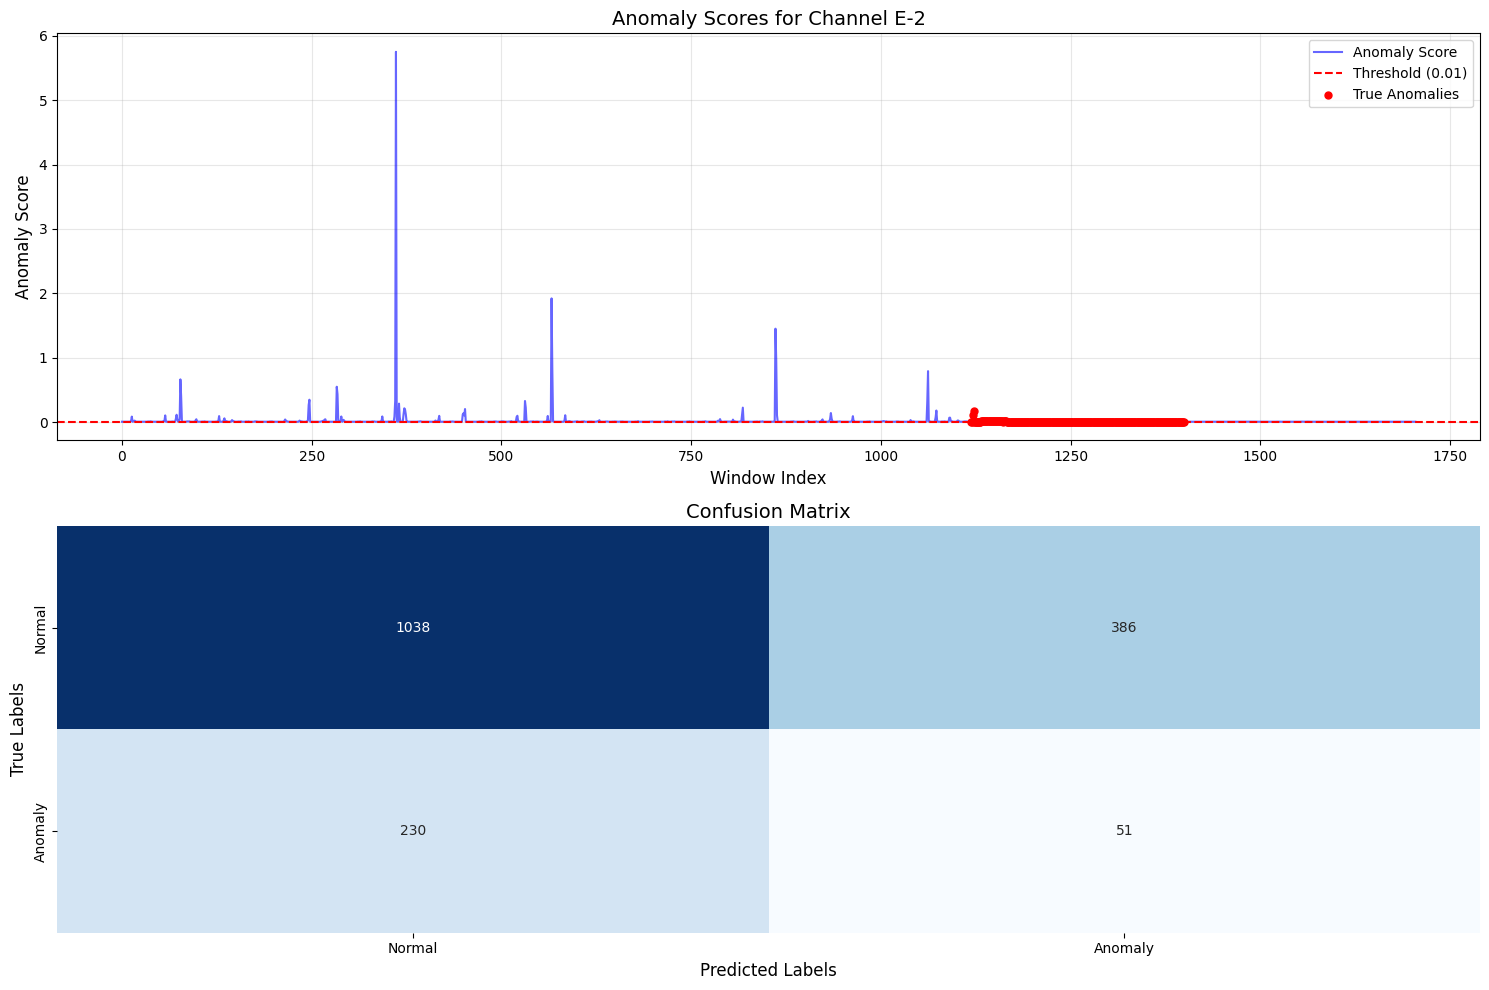


Metrics for channel E-2:
Accuracy: 0.6387
Precision: 0.1167
Recall: 0.1815
F1-Score: 0.1421

Processing channel: E-3

Channel E-3:
Train windows shape: (575, 10, 25)
Test windows shape: (1660, 10, 25)
Anomaly windows: 642/1660
Anomaly class: [point]
Epoch 1, Train Loss: 2.7707, Val Loss: 1.3969
Train MSE: 0.587136, Discrepancy: 21.836024
Epoch 2, Train Loss: 0.8258, Val Loss: 0.7507
Train MSE: 0.258777, Discrepancy: 5.669897
Epoch 3, Train Loss: 0.5077, Val Loss: 0.5742
Train MSE: 0.196208, Discrepancy: 3.114627
Epoch 4, Train Loss: 0.3712, Val Loss: 0.4627
Train MSE: 0.164065, Discrepancy: 2.070991
Epoch 5, Train Loss: 0.2805, Val Loss: 0.3901
Train MSE: 0.147603, Discrepancy: 1.329055
Epoch 6, Train Loss: 0.2314, Val Loss: 0.3519
Train MSE: 0.138904, Discrepancy: 0.924673
Epoch 7, Train Loss: 0.2022, Val Loss: 0.3242
Train MSE: 0.131895, Discrepancy: 0.702661
Epoch 8, Train Loss: 0.2097, Val Loss: 0.3069
Train MSE: 0.151209, Discrepancy: 0.585298
Epoch 9, Train Loss: 0.1693, Val Los

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 92.32it/s]


Computed threshold: 0.0081


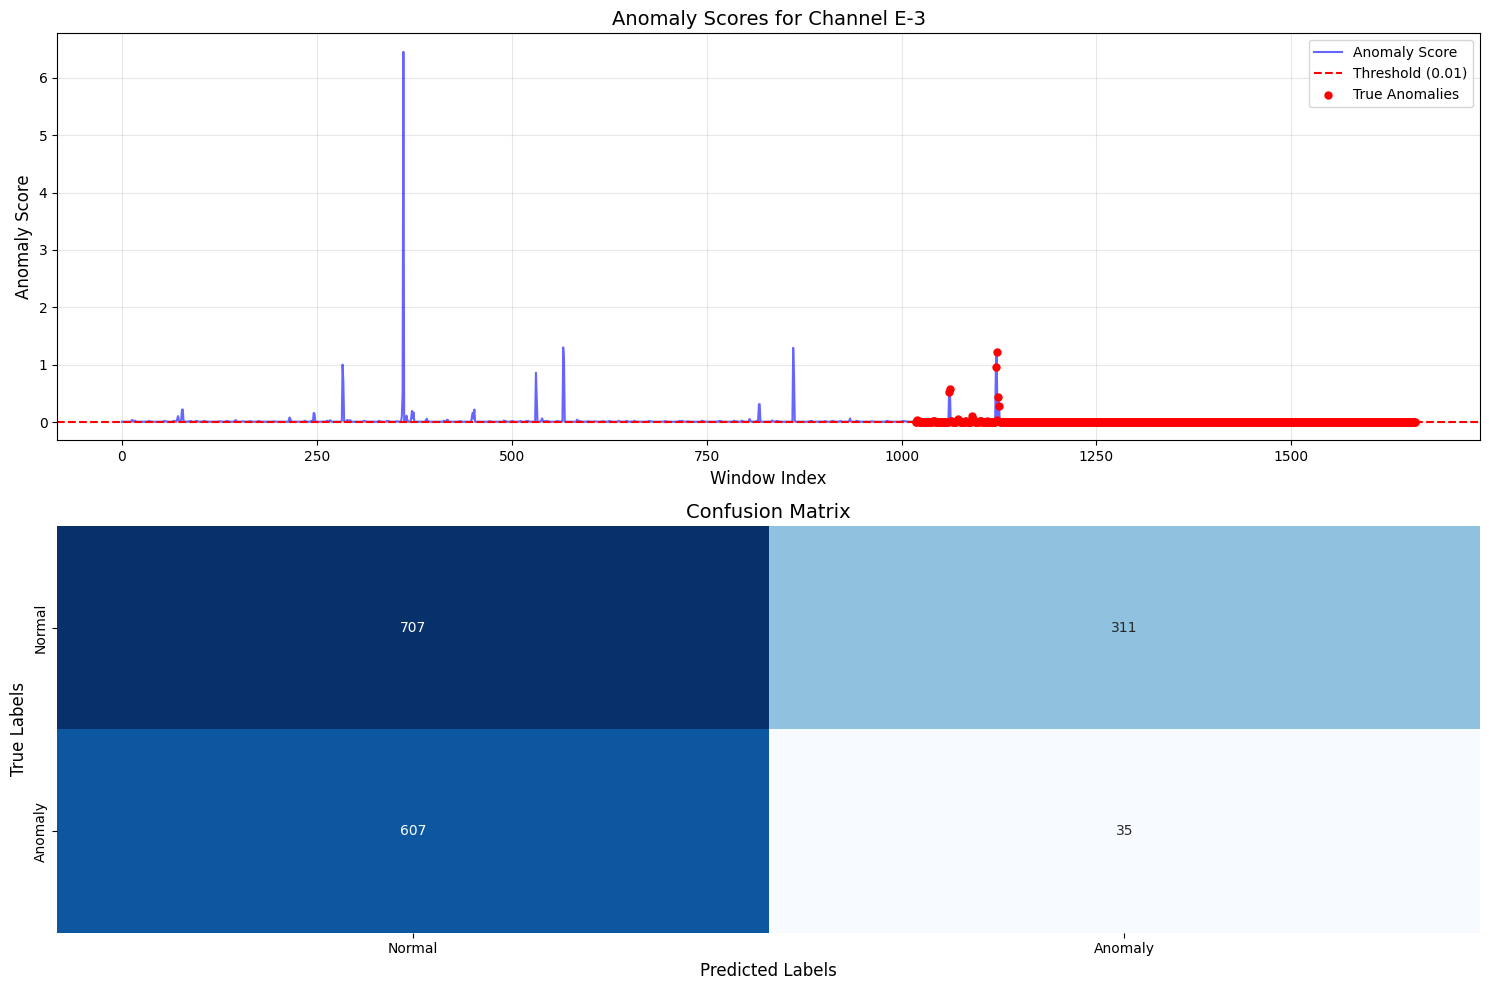


Metrics for channel E-3:
Accuracy: 0.4470
Precision: 0.1012
Recall: 0.0545
F1-Score: 0.0709

Processing channel: E-4

Channel E-4:
Train windows shape: (575, 10, 25)
Test windows shape: (1669, 10, 25)
Anomaly windows: 563/1669
Anomaly class: [point]
Epoch 1, Train Loss: 2.9437, Val Loss: 1.4418
Train MSE: 0.653163, Discrepancy: 22.905077
Epoch 2, Train Loss: 0.8537, Val Loss: 0.7508
Train MSE: 0.268325, Discrepancy: 5.853690
Epoch 3, Train Loss: 0.4991, Val Loss: 0.5667
Train MSE: 0.191525, Discrepancy: 3.075749
Epoch 4, Train Loss: 0.3654, Val Loss: 0.4515
Train MSE: 0.161629, Discrepancy: 2.037906
Epoch 5, Train Loss: 0.2761, Val Loss: 0.3827
Train MSE: 0.145452, Discrepancy: 1.306407
Epoch 6, Train Loss: 0.2267, Val Loss: 0.3454
Train MSE: 0.136701, Discrepancy: 0.899642
Epoch 7, Train Loss: 0.1991, Val Loss: 0.3235
Train MSE: 0.130842, Discrepancy: 0.682909
Epoch 8, Train Loss: 0.1814, Val Loss: 0.3031
Train MSE: 0.127054, Discrepancy: 0.543897
Epoch 9, Train Loss: 0.1674, Val Los

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 35.32it/s]



Computed threshold: 0.0097


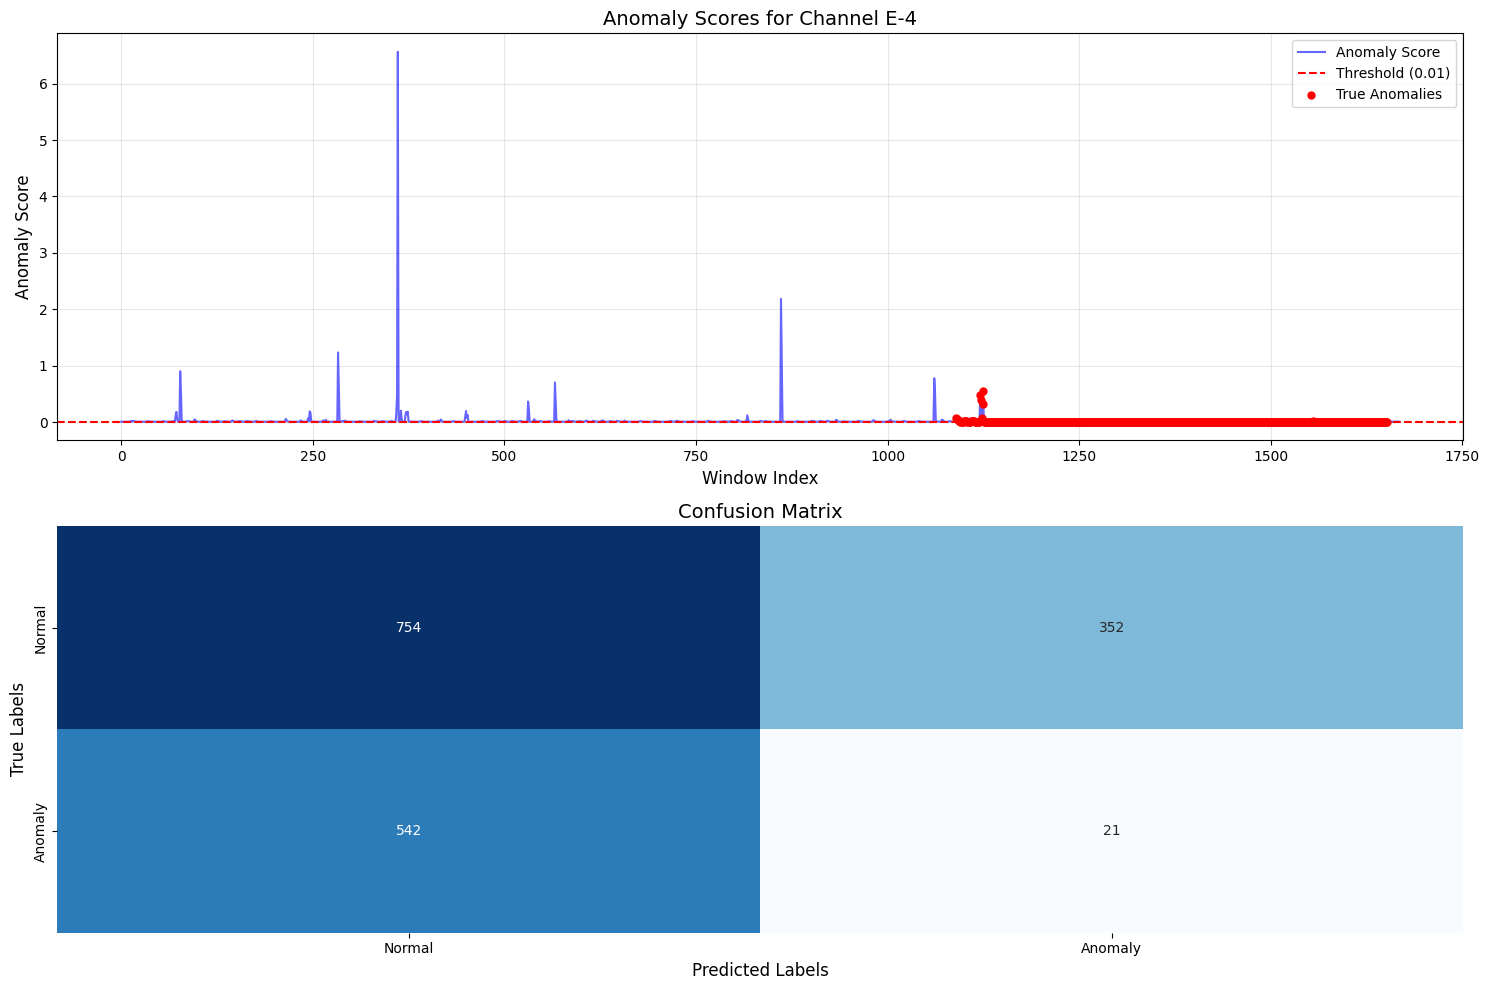


Metrics for channel E-4:
Accuracy: 0.4643
Precision: 0.0563
Recall: 0.0373
F1-Score: 0.0449

Processing channel: E-5

Channel E-5:
Train windows shape: (575, 10, 25)
Test windows shape: (1657, 10, 25)
Anomaly windows: 65/1657
Anomaly class: [point]

⚠️ WARNING: Skipping channel E-5 Insufficient anomaly windows

Processing channel: E-6

Channel E-6:
Train windows shape: (575, 10, 25)
Test windows shape: (1659, 10, 25)
Anomaly windows: 14/1659
Anomaly class: [point]

⚠️ WARNING: Skipping channel E-6 Insufficient anomaly windows

Processing channel: E-7

Channel E-7:
Train windows shape: (552, 10, 25)
Test windows shape: (1661, 10, 25)
Anomaly windows: 57/1661
Anomaly class: [point]

⚠️ WARNING: Skipping channel E-7 Insufficient anomaly windows

Processing channel: E-8

Channel E-8:
Train windows shape: (575, 10, 25)
Test windows shape: (1705, 10, 25)
Anomaly windows: 125/1705
Anomaly class: [point]
Epoch 1, Train Loss: 2.7141, Val Loss: 1.3858
Train MSE: 0.573105, Discrepancy: 21.409576

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 67.56it/s]



Computed threshold: 0.0073


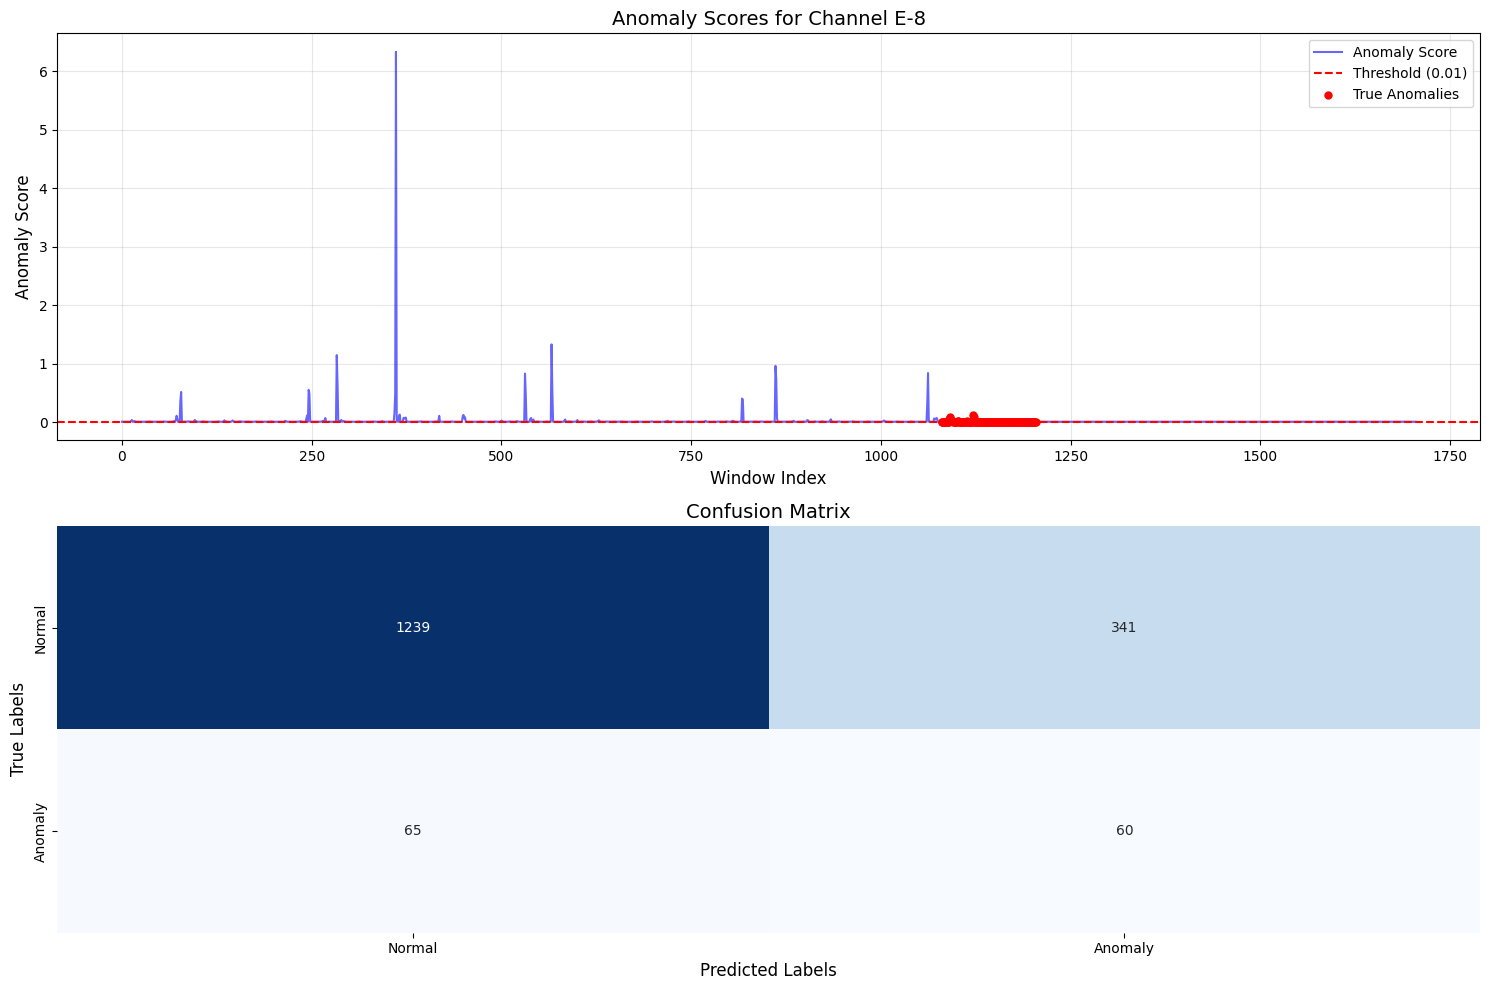


Metrics for channel E-8:
Accuracy: 0.7619
Precision: 0.1496
Recall: 0.4800
F1-Score: 0.2281

Processing channel: E-9

Channel E-9:
Train windows shape: (575, 10, 25)
Test windows shape: (1659, 10, 25)
Anomaly windows: 71/1659
Anomaly class: [point]

⚠️ WARNING: Skipping channel E-9 Insufficient anomaly windows

Processing channel: F-1

Channel F-1:
Train windows shape: (572, 10, 25)
Test windows shape: (1715, 10, 25)
Anomaly windows: 21/1715
Anomaly class: [point]

⚠️ WARNING: Skipping channel F-1 Insufficient anomaly windows

Processing channel: F-2

Channel F-2:
Train windows shape: (571, 10, 25)
Test windows shape: (1724, 10, 25)
Anomaly windows: 591/1724
Anomaly class: [point]
Epoch 1, Train Loss: 2.6312, Val Loss: 1.5213
Train MSE: 0.469053, Discrepancy: 21.621751
Epoch 2, Train Loss: 0.7011, Val Loss: 0.9562
Train MSE: 0.194670, Discrepancy: 5.064704
Epoch 3, Train Loss: 0.4513, Val Loss: 0.7788
Train MSE: 0.154501, Discrepancy: 2.967969
Epoch 4, Train Loss: 0.3368, Val Loss: 0.

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 40.70it/s]



Computed threshold: 0.0081


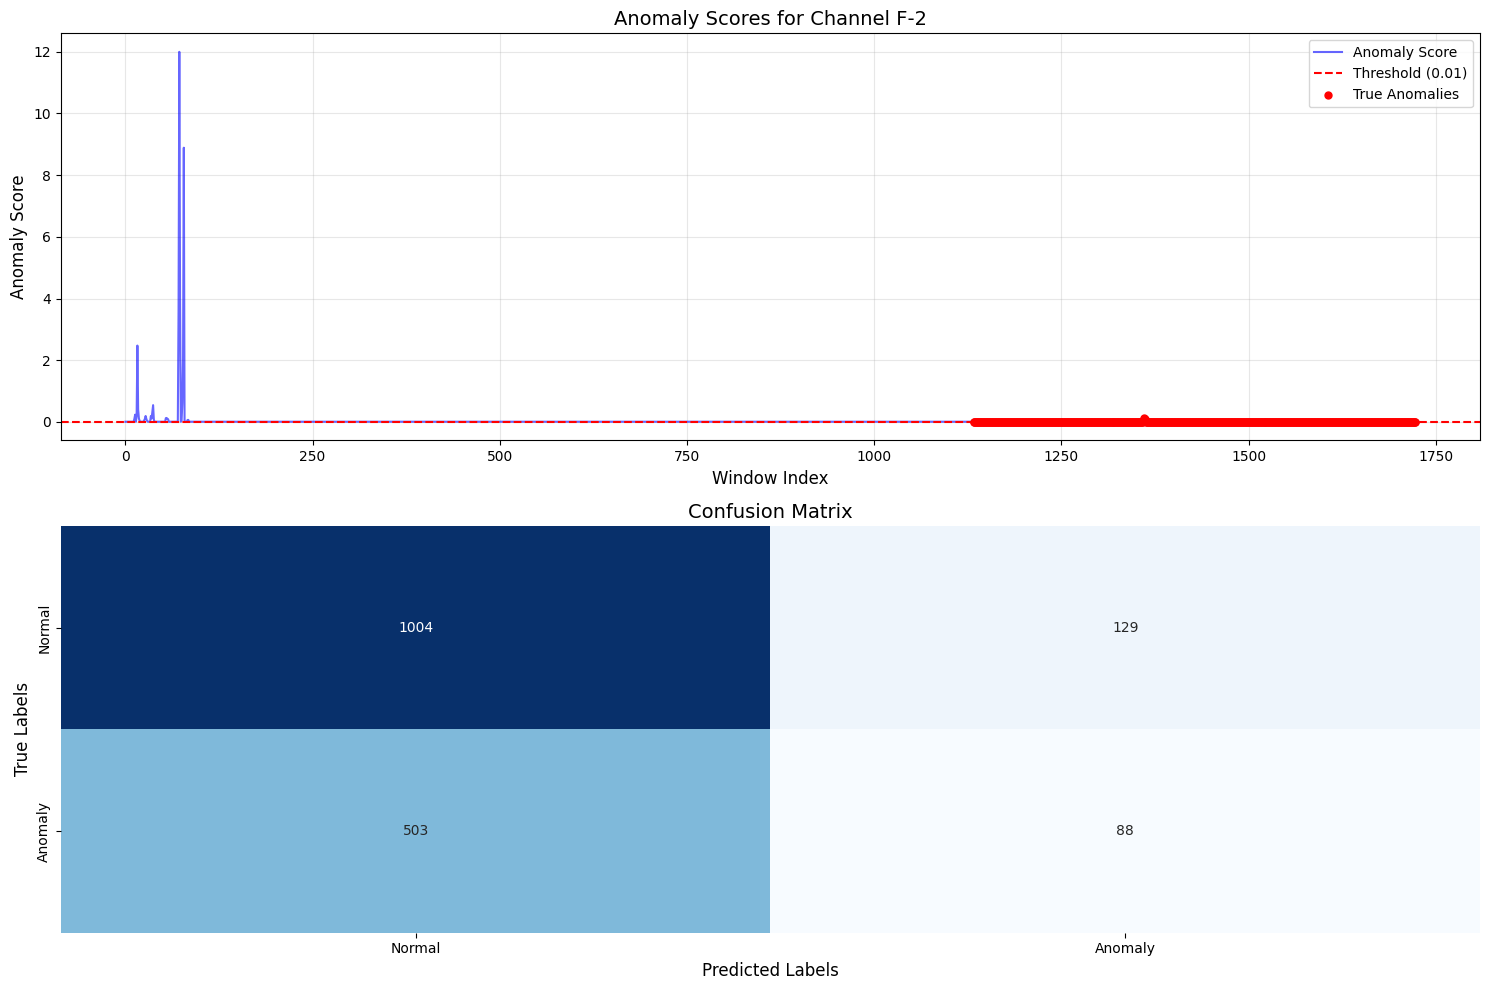


Metrics for channel F-2:
Accuracy: 0.6334
Precision: 0.4055
Recall: 0.1489
F1-Score: 0.2178

Processing channel: F-3

Channel F-3:
Train windows shape: (575, 10, 25)
Test windows shape: (1674, 10, 25)
Anomaly windows: 9/1674
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel F-3 Insufficient anomaly windows

Processing channel: F-4

Channel F-4:
Train windows shape: (447, 10, 55)
Test windows shape: (683, 10, 55)
Anomaly windows: 15/683
Anomaly class: [point]

⚠️ WARNING: Skipping channel F-4 Insufficient anomaly windows

Processing channel: F-5

Channel F-5:
Train windows shape: (518, 10, 55)
Test windows shape: (783, 10, 55)
Anomaly windows: 31/783
Anomaly class: [point]

⚠️ WARNING: Skipping channel F-5 Insufficient anomaly windows

Processing channel: F-7

Channel F-7:
Train windows shape: (501, 10, 55)
Test windows shape: (1009, 10, 55)
Anomaly windows: 87/1009
Anomaly class: [contextual, contextual, contextual]

⚠️ WARNING: Skipping channel F-7 Insufficient anomaly window

Computing threshold: 100%|██████████| 17/17 [00:00<00:00, 31.44it/s]



Computed threshold: 0.0051


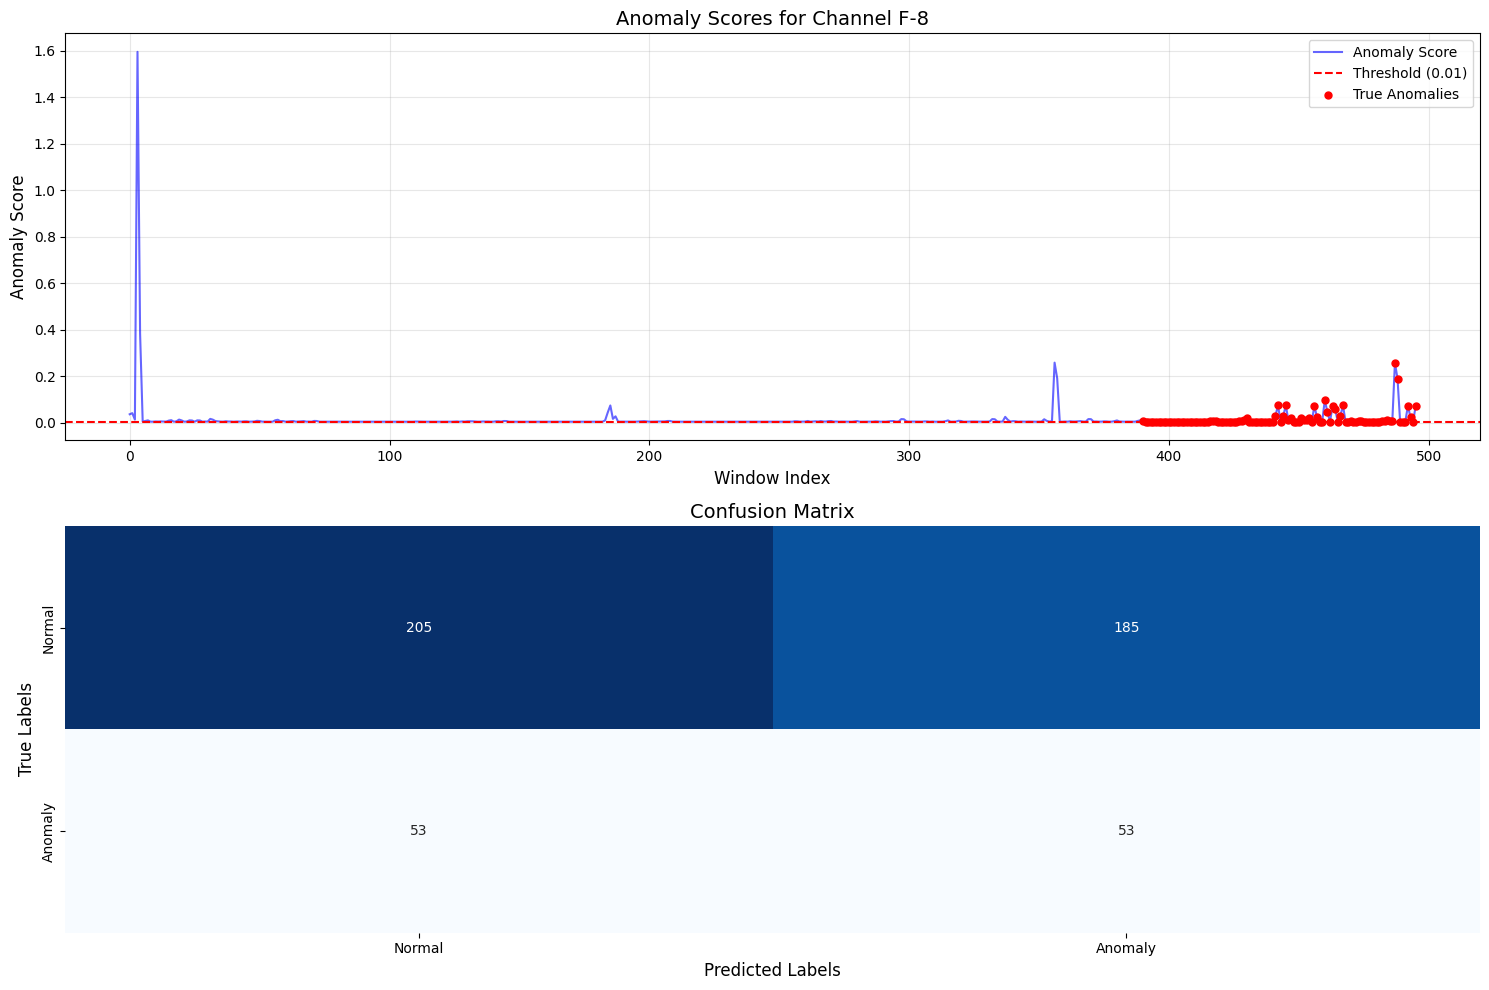


Metrics for channel F-8:
Accuracy: 0.5202
Precision: 0.2227
Recall: 0.5000
F1-Score: 0.3081

Processing channel: G-1

Channel G-1:
Train windows shape: (563, 10, 25)
Test windows shape: (1692, 10, 25)
Anomaly windows: 25/1692
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel G-1 Insufficient anomaly windows

Processing channel: G-2

Channel G-2:
Train windows shape: (494, 10, 25)
Test windows shape: (1471, 10, 25)
Anomaly windows: 9/1471
Anomaly class: [point]

⚠️ WARNING: Skipping channel G-2 Insufficient anomaly windows

Processing channel: G-3

Channel G-3:
Train windows shape: (523, 10, 25)
Test windows shape: (1580, 10, 25)
Anomaly windows: 11/1580
Anomaly class: [point]

⚠️ WARNING: Skipping channel G-3 Insufficient anomaly windows

Processing channel: G-4

Channel G-4:
Train windows shape: (509, 10, 25)
Test windows shape: (1525, 10, 25)
Anomaly windows: 7/1525
Anomaly class: [point]

⚠️ WARNING: Skipping channel G-4 Insufficient anomaly windows

Processing channel: G-6

Computing threshold: 100%|██████████| 11/11 [00:00<00:00, 44.83it/s]



Computed threshold: 0.0071


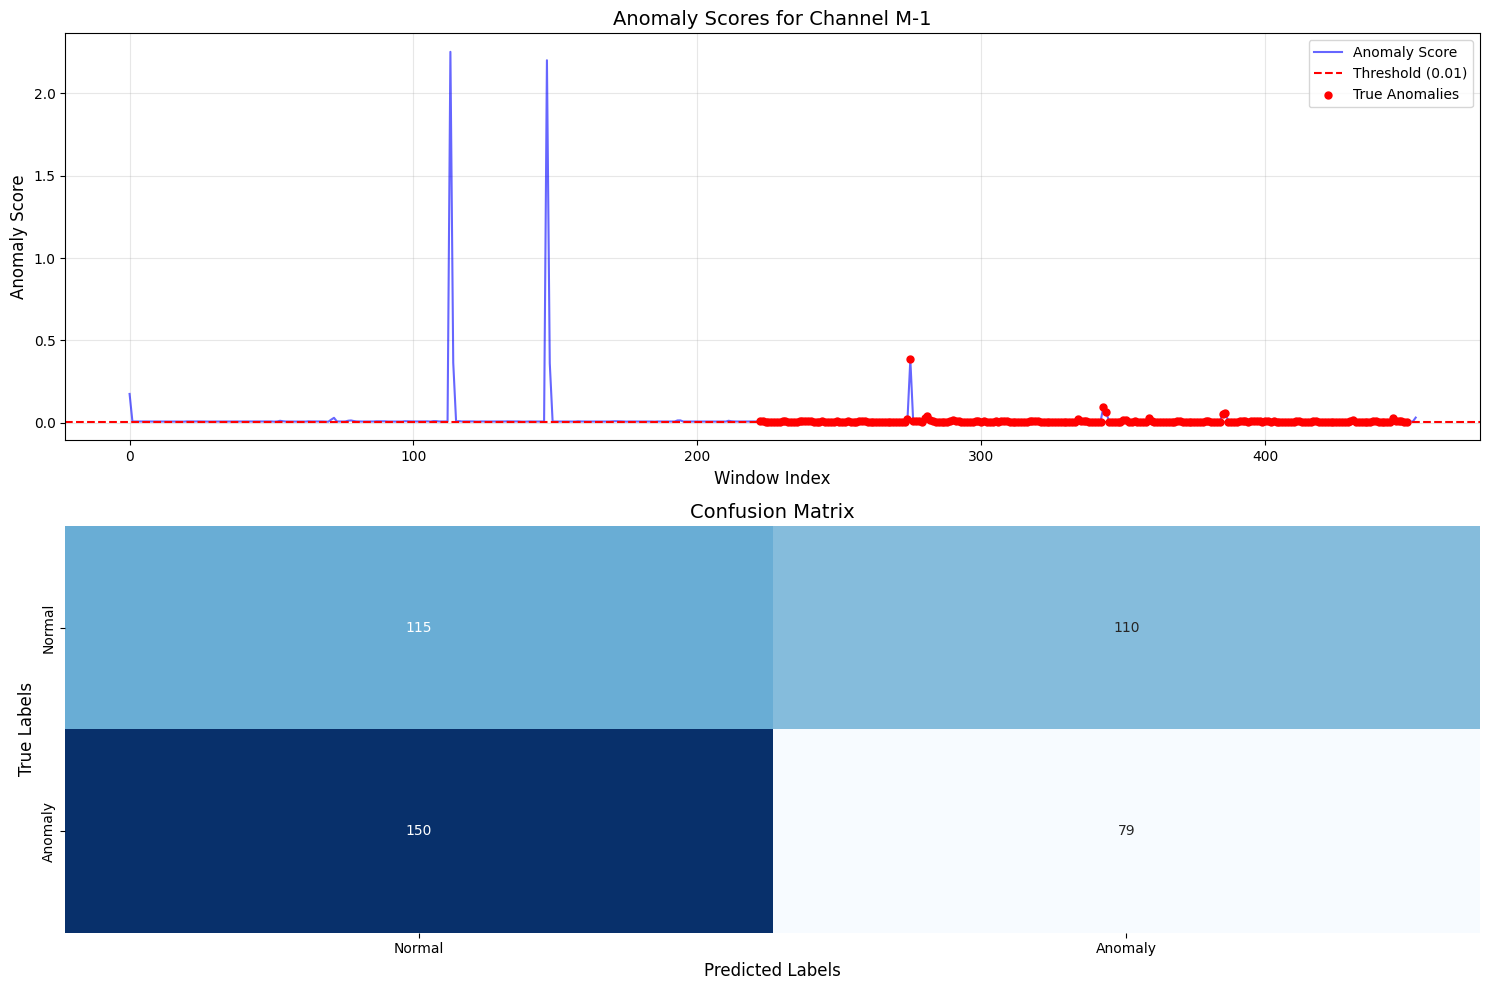


Metrics for channel M-1:
Accuracy: 0.4273
Precision: 0.4180
Recall: 0.3450
F1-Score: 0.3780

Processing channel: M-2

Channel M-2:
Train windows shape: (440, 10, 55)
Test windows shape: (454, 10, 55)
Anomaly windows: 229/454
Anomaly class: [contextual]
Epoch 1, Train Loss: 2.9002, Val Loss: 1.2396
Train MSE: 0.357762, Discrepancy: 25.424571
Epoch 2, Train Loss: 0.8858, Val Loss: 0.5869
Train MSE: 0.201241, Discrepancy: 6.845983
Epoch 3, Train Loss: 0.4984, Val Loss: 0.3897
Train MSE: 0.136801, Discrepancy: 3.615595
Epoch 4, Train Loss: 0.3638, Val Loss: 0.2851
Train MSE: 0.100496, Discrepancy: 2.632696
Epoch 5, Train Loss: 0.2685, Val Loss: 0.2042
Train MSE: 0.082754, Discrepancy: 1.857736
Epoch 6, Train Loss: 0.1993, Val Loss: 0.1527
Train MSE: 0.071875, Discrepancy: 1.273888
Epoch 7, Train Loss: 0.1586, Val Loss: 0.1238
Train MSE: 0.065010, Discrepancy: 0.936118
Epoch 8, Train Loss: 0.1343, Val Loss: 0.1054
Train MSE: 0.061180, Discrepancy: 0.731099
Epoch 9, Train Loss: 0.1183, Val 

Computing threshold: 100%|██████████| 11/11 [00:00<00:00, 27.50it/s]



Computed threshold: 0.0073


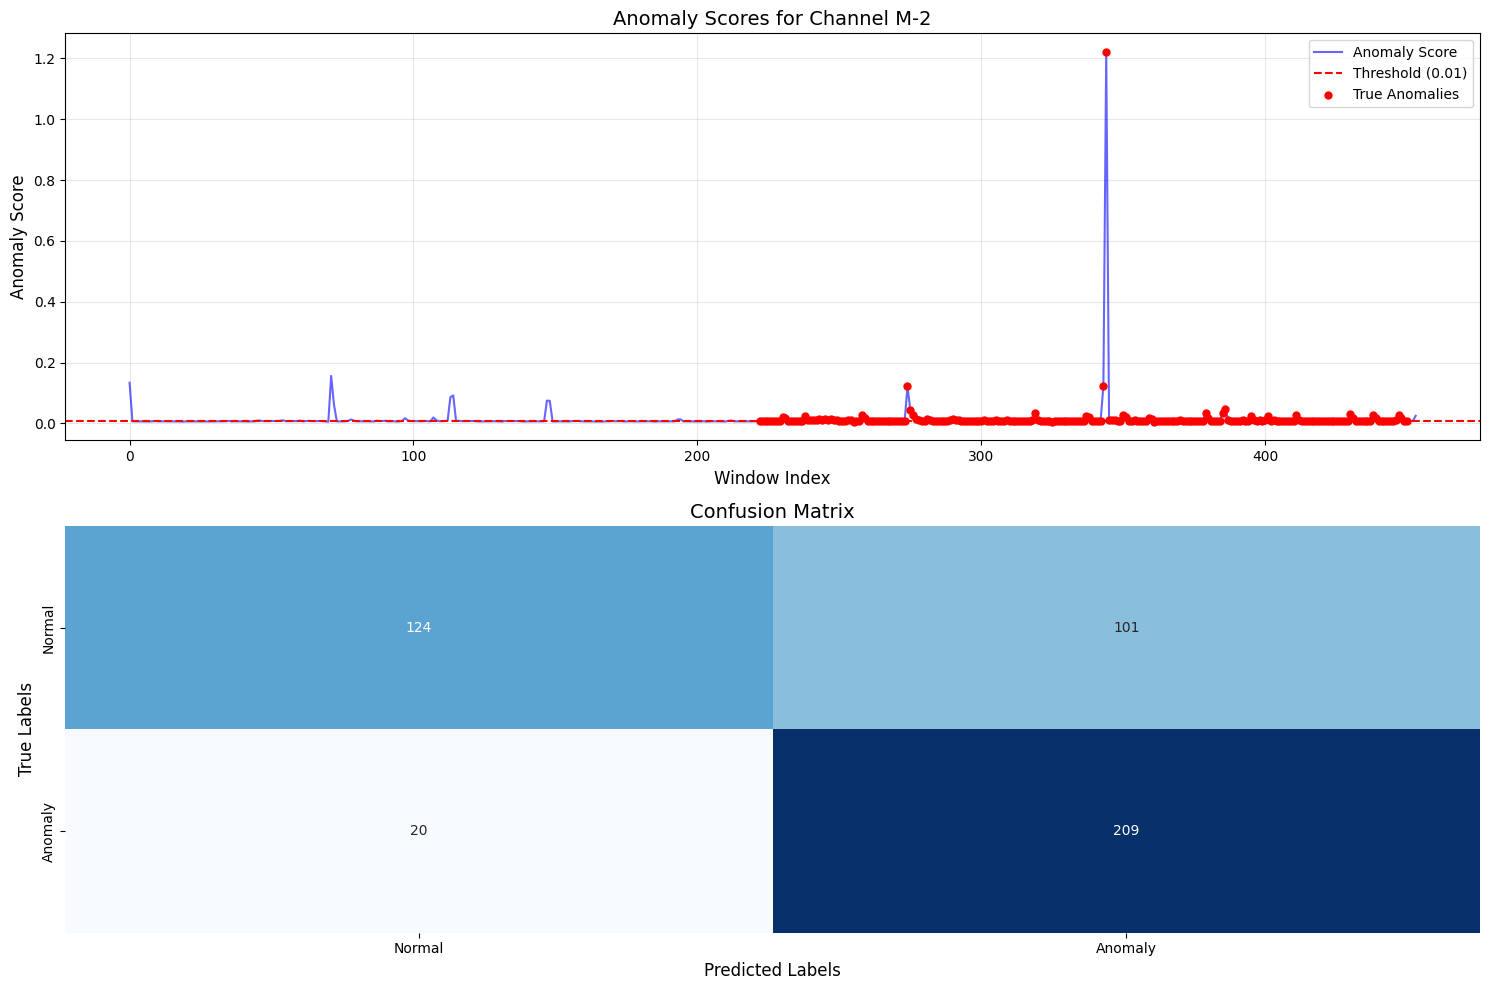


Metrics for channel M-2:
Accuracy: 0.7335
Precision: 0.6742
Recall: 0.9127
F1-Score: 0.7755

Processing channel: M-3

Channel M-3:
Train windows shape: (406, 10, 55)
Test windows shape: (424, 10, 55)
Anomaly windows: 51/424
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel M-3 Insufficient anomaly windows

Processing channel: M-4

Channel M-4:
Train windows shape: (414, 10, 55)
Test windows shape: (406, 10, 55)
Anomaly windows: 51/406
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel M-4 Insufficient anomaly windows

Processing channel: M-5

Channel M-5:
Train windows shape: (405, 10, 55)
Test windows shape: (459, 10, 55)
Anomaly windows: 61/459
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel M-5 Insufficient anomaly windows

Processing channel: M-6

Channel M-6:
Train windows shape: (312, 10, 55)
Test windows shape: (408, 10, 55)
Anomaly windows: 37/408
Anomaly class: [point]

⚠️ WARNING: Skipping channel M-6 Insufficient anomaly windows

Processing channel:

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 27.58it/s]



Computed threshold: 0.0062


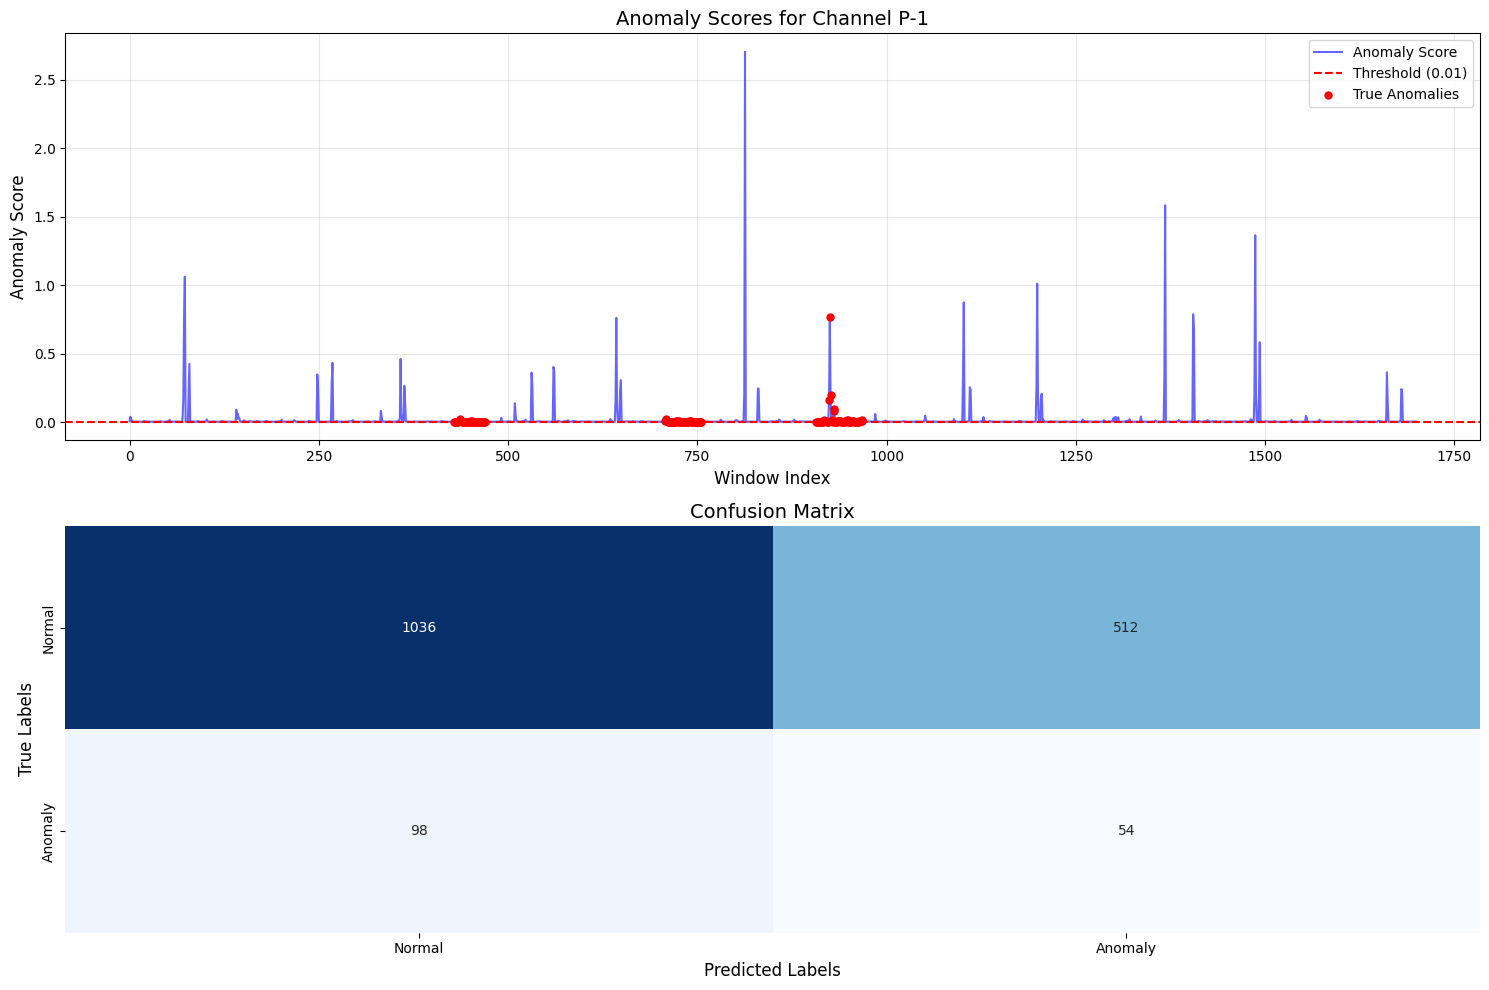


Metrics for channel P-1:
Accuracy: 0.6412
Precision: 0.0954
Recall: 0.3553
F1-Score: 0.1504

Processing channel: P-10

Channel P-10:
Train windows shape: (860, 10, 55)
Test windows shape: (1219, 10, 55)
Anomaly windows: 27/1219
Anomaly class: [point]

⚠️ WARNING: Skipping channel P-10 Insufficient anomaly windows

Processing channel: P-11

Channel P-11:
Train windows shape: (792, 10, 55)
Test windows shape: (706, 10, 55)
Anomaly windows: 47/706
Anomaly class: [point, point]

⚠️ WARNING: Skipping channel P-11 Insufficient anomaly windows

Processing channel: P-14

Channel P-14:
Train windows shape: (575, 10, 55)
Test windows shape: (1219, 10, 55)
Anomaly windows: 37/1219
Anomaly class: [point]

⚠️ WARNING: Skipping channel P-14 Insufficient anomaly windows

Processing channel: P-15

Channel P-15:
Train windows shape: (735, 10, 55)
Test windows shape: (570, 10, 55)
Anomaly windows: 5/570
Anomaly class: [point]

⚠️ WARNING: Skipping channel P-15 Insufficient anomaly windows

Processing c

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 46.41it/s]



Computed threshold: 0.0069


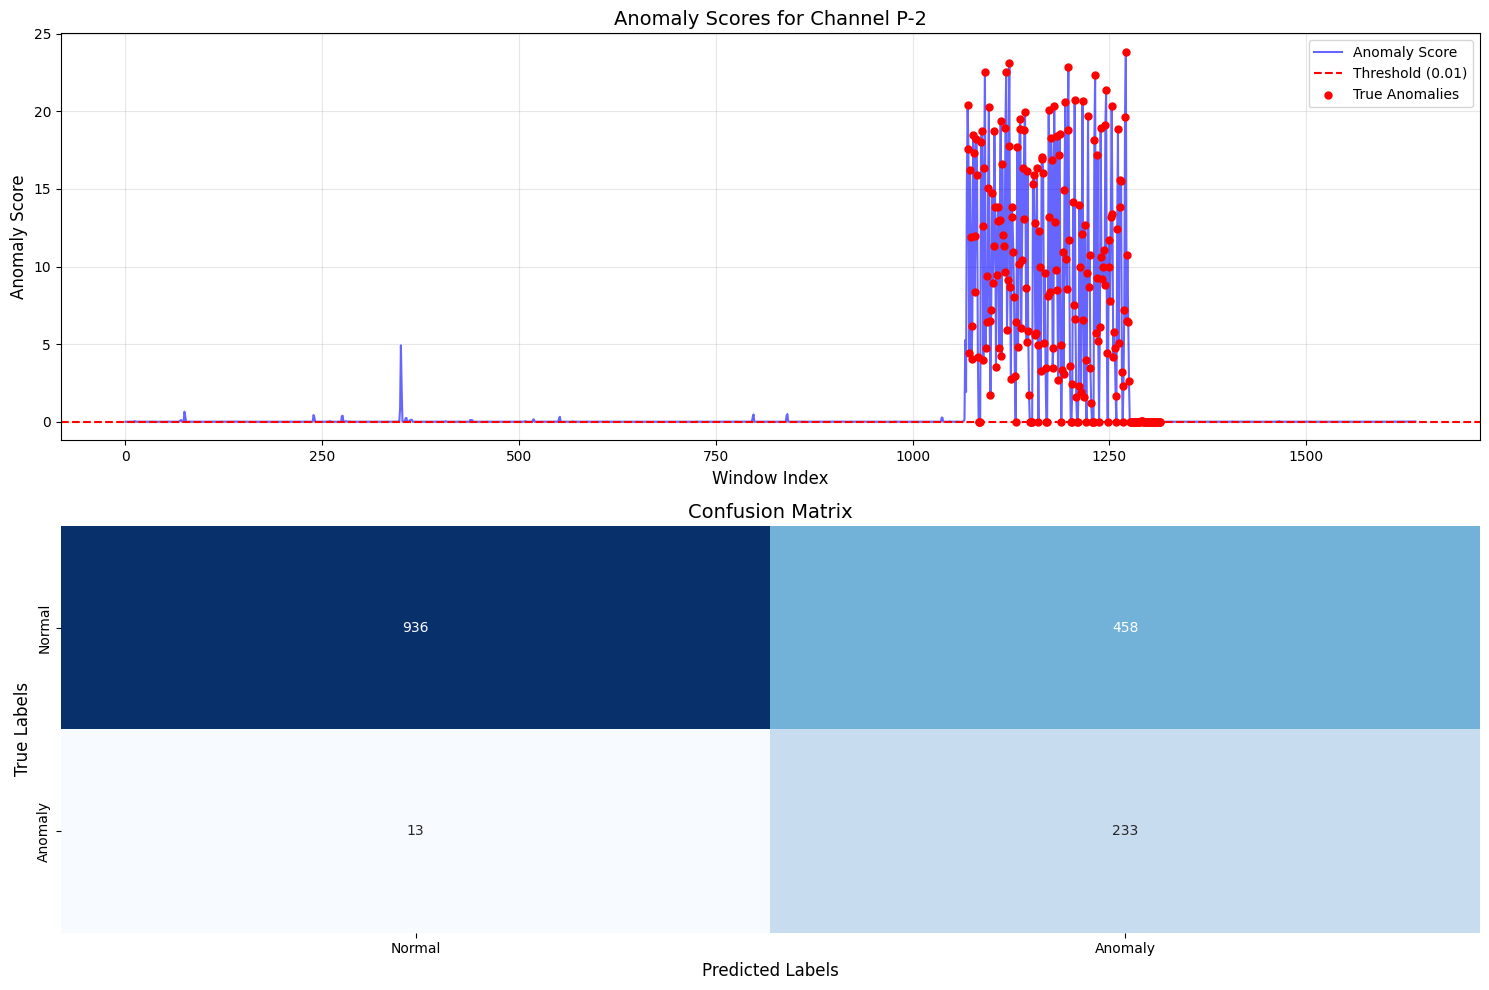


Metrics for channel P-2:
Accuracy: 0.7128
Precision: 0.3372
Recall: 0.9472
F1-Score: 0.4973

Processing channel: P-3

Channel P-3:
Train windows shape: (570, 10, 25)
Test windows shape: (1697, 10, 25)
Anomaly windows: 268/1697
Anomaly class: [point]
Epoch 1, Train Loss: 2.9432, Val Loss: 1.3048
Train MSE: 0.637678, Discrepancy: 23.054901
Epoch 2, Train Loss: 0.8710, Val Loss: 0.6803
Train MSE: 0.295351, Discrepancy: 5.756032
Epoch 3, Train Loss: 0.5282, Val Loss: 0.5189
Train MSE: 0.217244, Discrepancy: 3.109793
Epoch 4, Train Loss: 0.3961, Val Loss: 0.3984
Train MSE: 0.186648, Discrepancy: 2.094070
Epoch 5, Train Loss: 0.3128, Val Loss: 0.3359
Train MSE: 0.176182, Discrepancy: 1.366290
Epoch 6, Train Loss: 0.2572, Val Loss: 0.2978
Train MSE: 0.160338, Discrepancy: 0.968369
Epoch 7, Train Loss: 0.2287, Val Loss: 0.2743
Train MSE: 0.153963, Discrepancy: 0.747160
Epoch 8, Train Loss: 0.2071, Val Loss: 0.2579
Train MSE: 0.147173, Discrepancy: 0.599275
Epoch 9, Train Loss: 0.1927, Val Los

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 48.97it/s]



Computed threshold: 0.0073


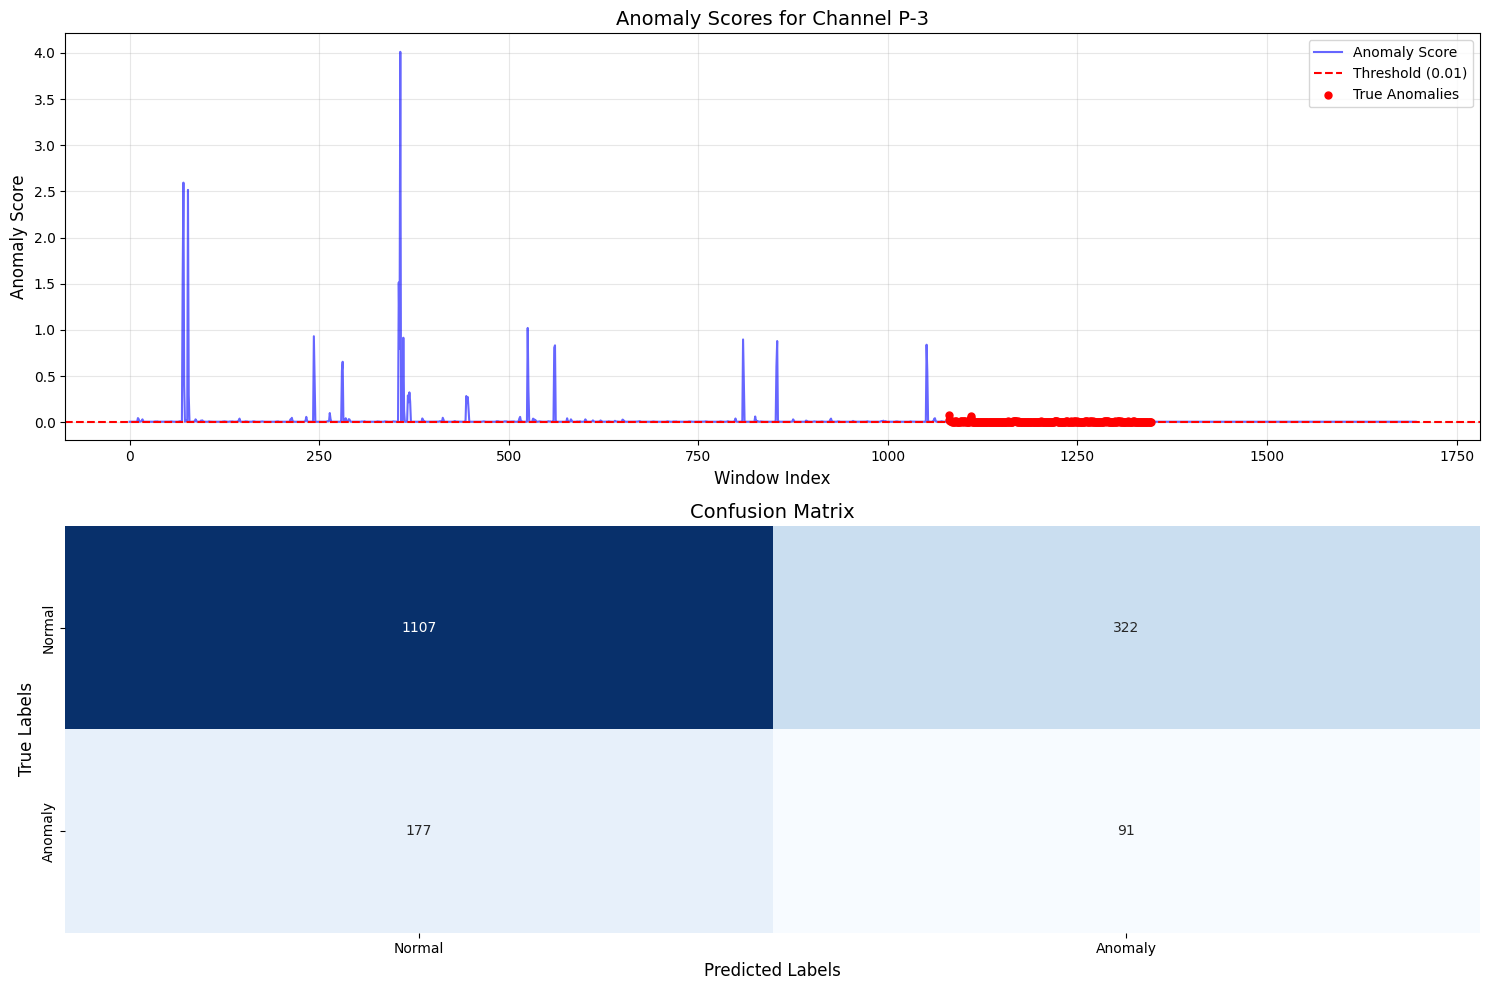


Metrics for channel P-3:
Accuracy: 0.7060
Precision: 0.2203
Recall: 0.3396
F1-Score: 0.2673

Processing channel: P-4

Channel P-4:
Train windows shape: (520, 10, 25)
Test windows shape: (1555, 10, 25)
Anomaly windows: 91/1555
Anomaly class: [point, point, point]

⚠️ WARNING: Skipping channel P-4 Insufficient anomaly windows

Processing channel: P-7

Channel P-7:
Train windows shape: (569, 10, 25)
Test windows shape: (1613, 10, 25)
Anomaly windows: 331/1613
Anomaly class: [contextual]
Epoch 1, Train Loss: 2.5850, Val Loss: 0.8945
Train MSE: 0.427212, Discrepancy: 21.577820
Epoch 2, Train Loss: 0.6549, Val Loss: 0.3858
Train MSE: 0.156634, Discrepancy: 4.982694
Epoch 3, Train Loss: 0.4039, Val Loss: 0.2670
Train MSE: 0.124083, Discrepancy: 2.797839
Epoch 4, Train Loss: 0.2968, Val Loss: 0.1747
Train MSE: 0.111429, Discrepancy: 1.853564
Epoch 5, Train Loss: 0.2770, Val Loss: 0.1307
Train MSE: 0.157752, Discrepancy: 1.192797
Epoch 6, Train Loss: 0.1748, Val Loss: 0.1003
Train MSE: 0.09091

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 85.65it/s]



Computed threshold: 0.0062


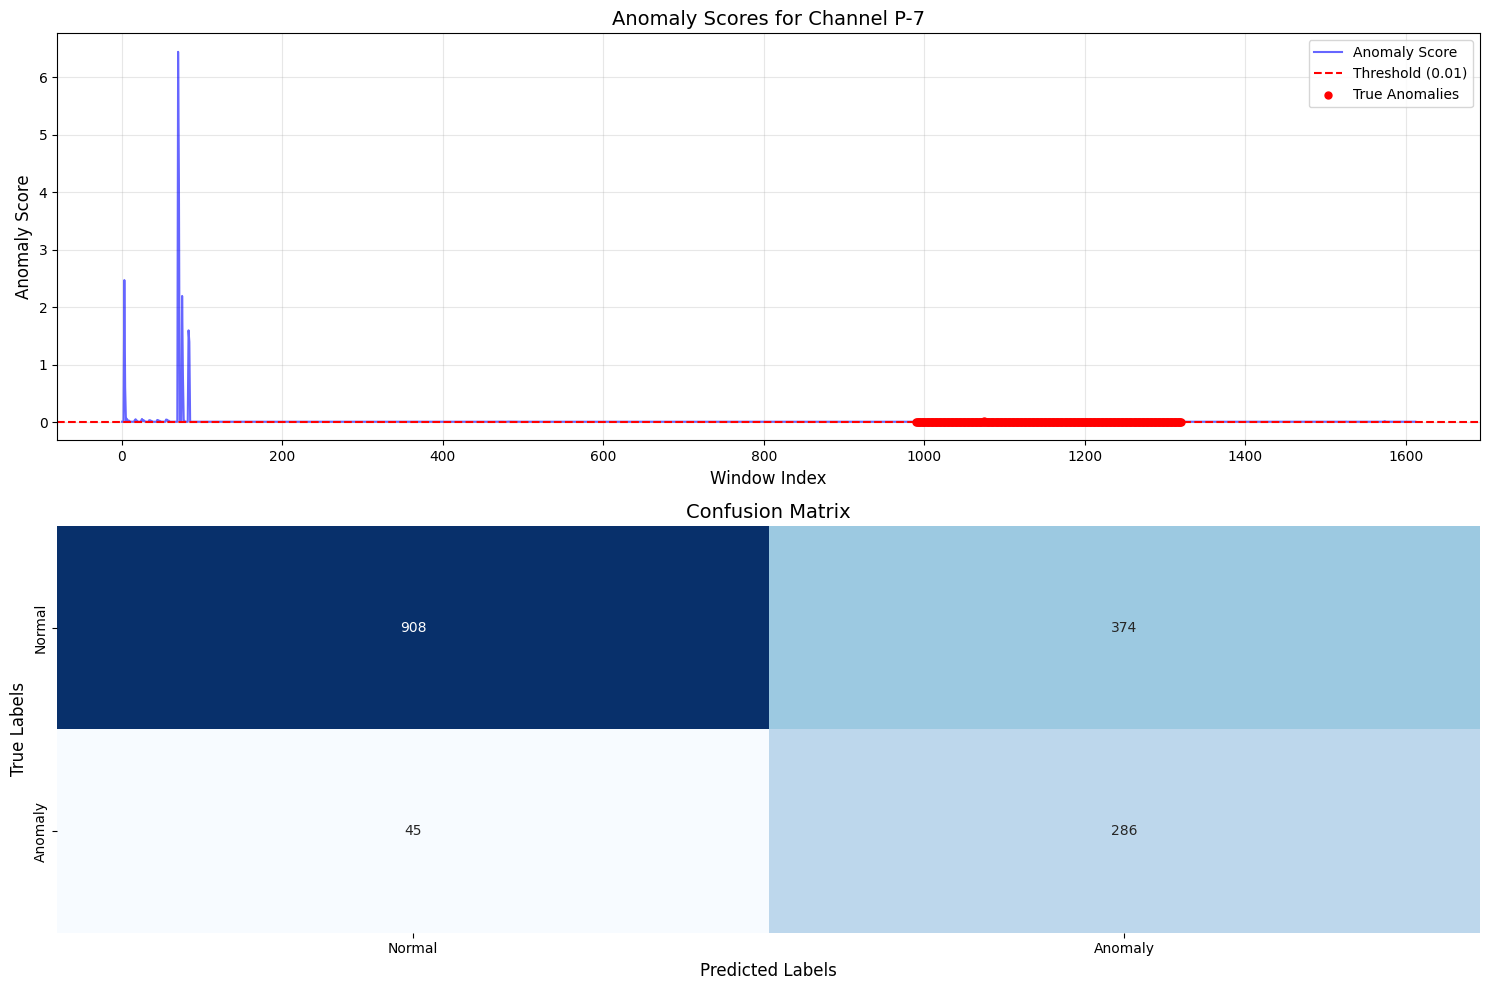


Metrics for channel P-7:
Accuracy: 0.7402
Precision: 0.4333
Recall: 0.8640
F1-Score: 0.5772

Processing channel: R-1

Channel R-1:
Train windows shape: (573, 10, 25)
Test windows shape: (1447, 10, 25)
Anomaly windows: 17/1447
Anomaly class: [point]

⚠️ WARNING: Skipping channel R-1 Insufficient anomaly windows

Processing channel: S-1

Channel S-1:
Train windows shape: (562, 10, 25)
Test windows shape: (1465, 10, 25)
Anomaly windows: 90/1465
Anomaly class: [point]

⚠️ WARNING: Skipping channel S-1 Insufficient anomaly windows

Processing channel: S-2

Channel S-2:
Train windows shape: (184, 10, 55)
Test windows shape: (364, 10, 55)
Anomaly windows: 3/364
Anomaly class: [point]

⚠️ WARNING: Skipping channel S-2 Insufficient anomaly windows

Processing channel: T-1

Channel T-1:
Train windows shape: (574, 10, 25)
Test windows shape: (1721, 10, 25)
Anomaly windows: 309/1721
Anomaly class: [point, contextual]
Epoch 1, Train Loss: 2.3788, Val Loss: 0.7805
Train MSE: 0.239100, Discrepancy: 

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 26.59it/s]



Computed threshold: 0.0073


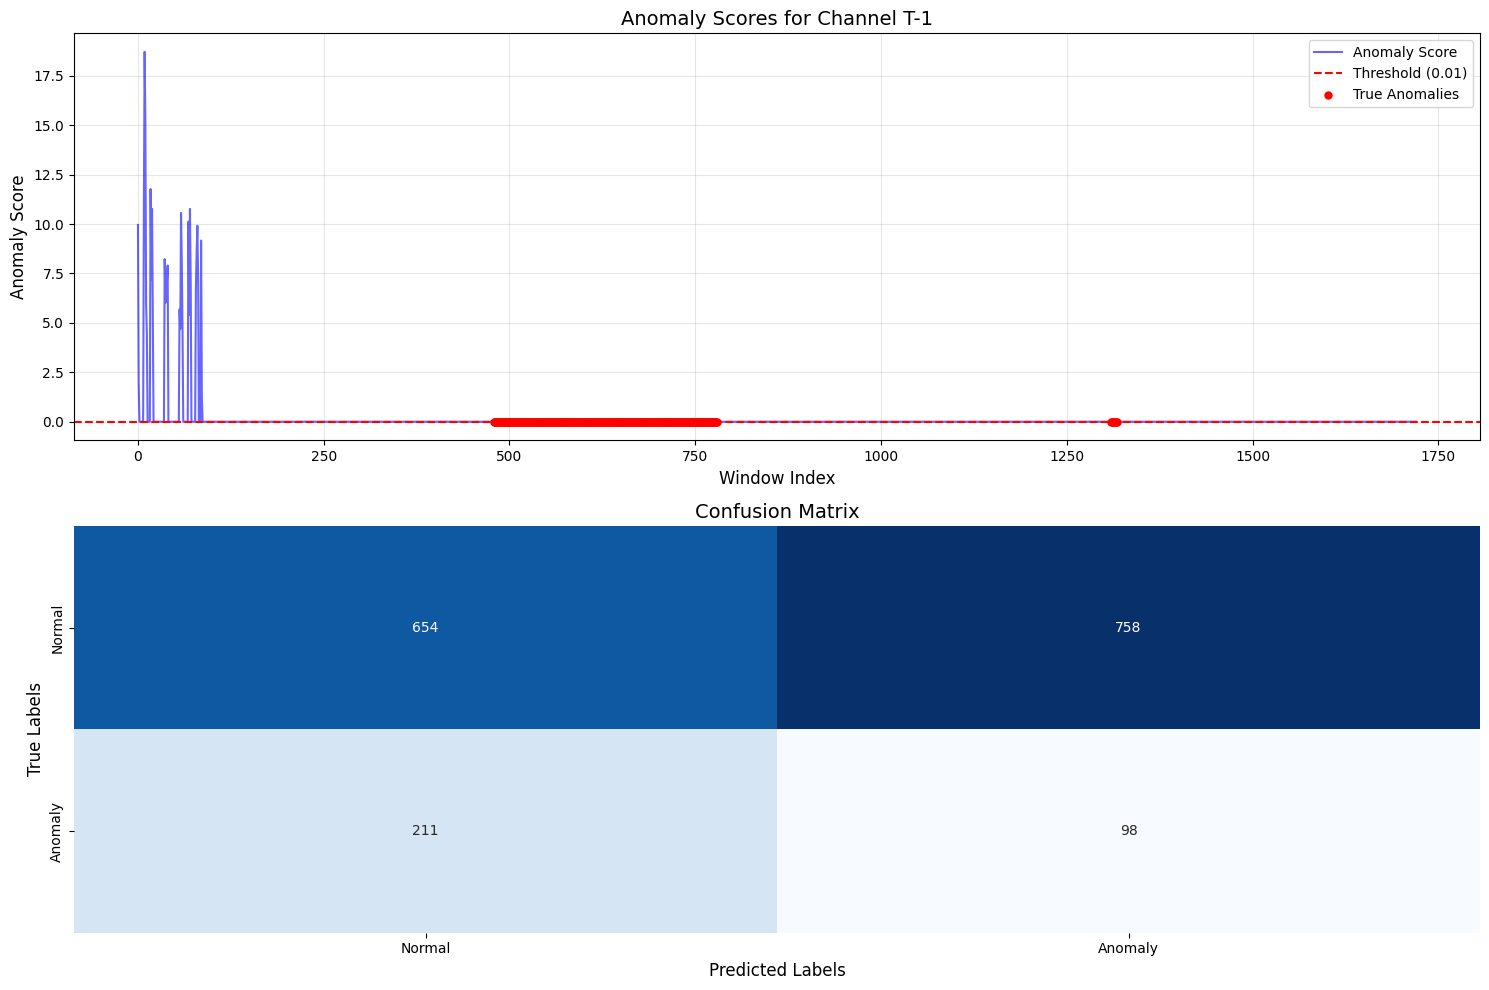


Metrics for channel T-1:
Accuracy: 0.4370
Precision: 0.1145
Recall: 0.3172
F1-Score: 0.1682

Processing channel: T-10

⚠️ WARNING: No labels found for channel T-10

Processing channel: T-12

Channel T-12:
Train windows shape: (228, 10, 55)
Test windows shape: (485, 10, 55)
Anomaly windows: 25/485
Anomaly class: [contextual]

⚠️ WARNING: Skipping channel T-12 Insufficient anomaly windows

Processing channel: T-13

Channel T-13:
Train windows shape: (228, 10, 55)
Test windows shape: (485, 10, 55)
Anomaly windows: 52/485
Anomaly class: [contextual, contextual]

⚠️ WARNING: Skipping channel T-13 Insufficient anomaly windows

Processing channel: T-2

Channel T-2:
Train windows shape: (570, 10, 25)
Test windows shape: (1724, 10, 25)
Anomaly windows: 356/1724
Anomaly class: [point]
Epoch 1, Train Loss: 2.6538, Val Loss: 1.6019
Train MSE: 0.495177, Discrepancy: 21.586036
Epoch 2, Train Loss: 0.7173, Val Loss: 0.9600
Train MSE: 0.203597, Discrepancy: 5.136647
Epoch 3, Train Loss: 0.4490, Val L

Computing threshold: 100%|██████████| 15/15 [00:00<00:00, 84.95it/s]


Computed threshold: 0.0050


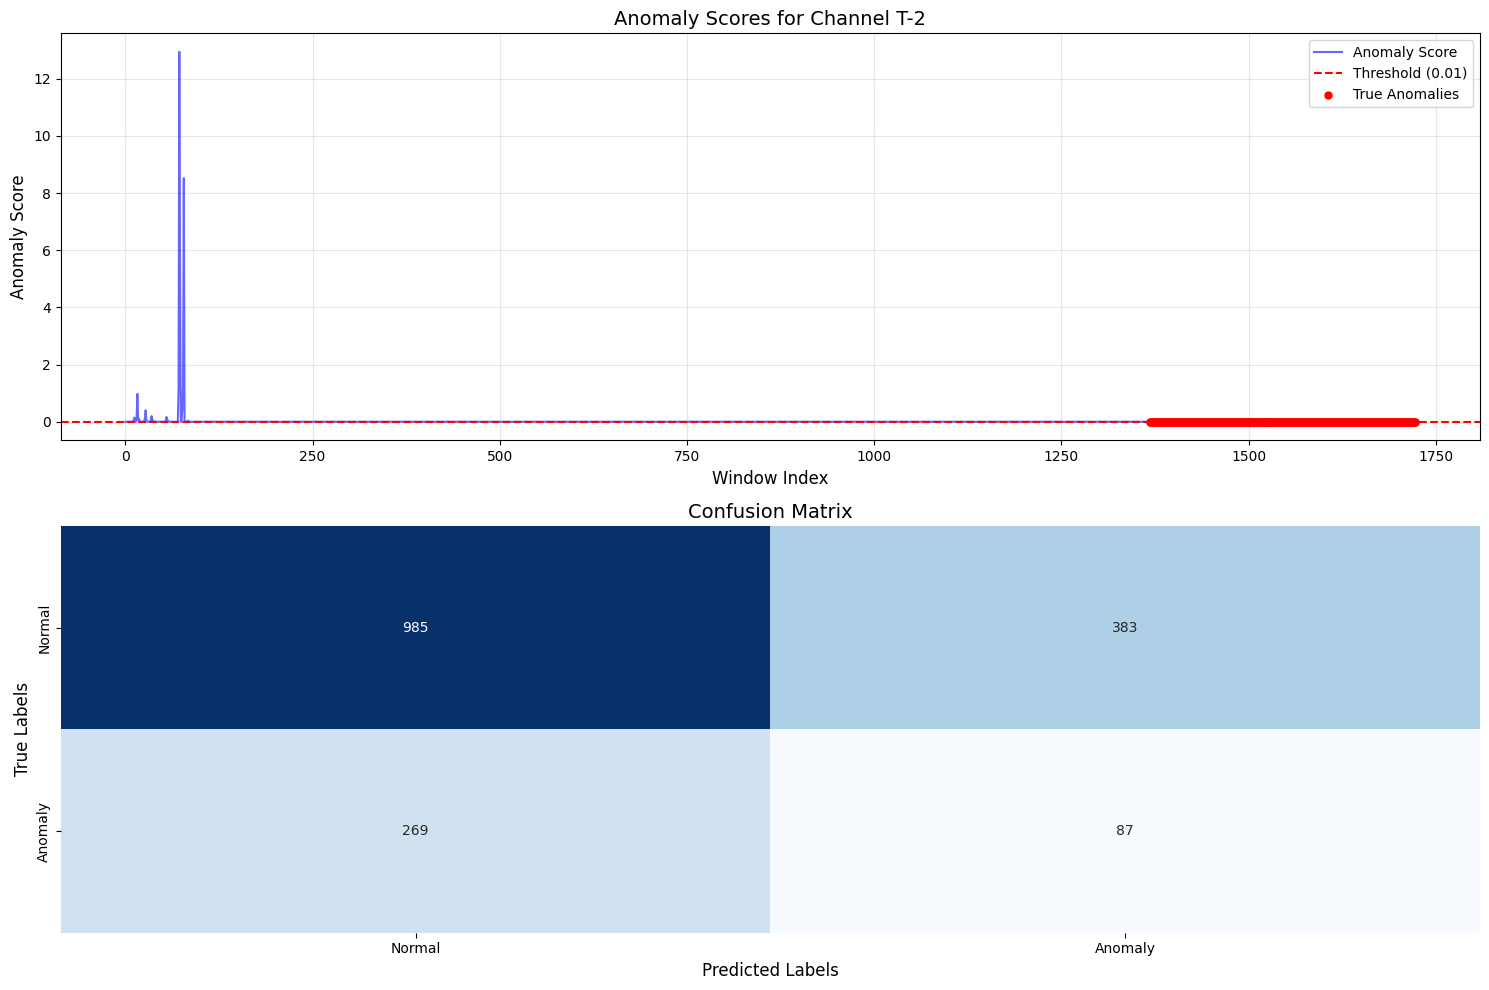


Metrics for channel T-2:
Accuracy: 0.6218
Precision: 0.1851
Recall: 0.2444
F1-Score: 0.2107

Processing channel: T-3

Channel T-3:
Train windows shape: (574, 10, 25)
Test windows shape: (1714, 10, 25)
Anomaly windows: 39/1714
Anomaly class: [point, point]

⚠️ WARNING: Skipping channel T-3 Insufficient anomaly windows

Processing channel: T-4

Channel T-4:
Train windows shape: (453, 10, 55)
Test windows shape: (442, 10, 55)
Anomaly windows: 15/442
Anomaly class: [point]

⚠️ WARNING: Skipping channel T-4 Insufficient anomaly windows

Processing channel: T-5

Channel T-5:
Train windows shape: (453, 10, 55)
Test windows shape: (442, 10, 55)
Anomaly windows: 6/442
Anomaly class: [point]

⚠️ WARNING: Skipping channel T-5 Insufficient anomaly windows

Processing channel: T-8

Channel T-8:
Train windows shape: (148, 10, 55)
Test windows shape: (302, 10, 55)
Anomaly windows: 22/302
Anomaly class: [contextual, contextual]

⚠️ WARNING: Skipping channel T-8 Insufficient anomaly windows

Processin

In [145]:
if __name__ == "__main__":
    # Get list of all channels
    channels = get_channel_names(cfg.base_path)
    results = {}
    skipped_channels = []
    
    # Process all channels
    for channel_name in channels:
        print(f"\n{'='*50}")
        print(f"Processing channel: {channel_name}")
        print(f"{'='*50}")
    
        # Load data for selected channel
        result = load_and_preprocess_data(channel_name, cfg.base_path)
        
    
        if result is None:
            skipped_channels.append({'channel': channel_name, 'reason': 'No labels found'})
            continue
        
        # Unpack the result tuple
        train_windows, test_windows, test_labels, scaler = result
        
        
        
        # Check for minimum anomaly windows
        anomaly_count = int(test_labels.sum())
        if anomaly_count < cfg.min_anomaly_windows:
            skipped_channels.append({
                'channel': channel_name,
                'anomaly_count': anomaly_count,
                'reason': f'Insufficient anomaly windows (minimum {cfg.min_anomaly_windows} required)'
            })
            print(f"\n⚠️ WARNING: Skipping channel {channel_name} Insufficient anomaly windows")
            # print(f"Found only {anomaly_count} anomaly windows (minimum {min_anomaly_windows} required)")
            continue
        
        
        train_windows, val_windows = train_test_split(train_windows, test_size=0.2, random_state=42)


        # Create datasets and dataloaders
        train_ds = TimeSeriesDataset(train_windows)
        val_ds = TimeSeriesDataset(val_windows)  # Create validation dataset
        test_ds = TimeSeriesDataset(test_windows, test_labels)
        
        train_loader = DataLoader(
            train_ds, 
            batch_size=cfg.batch_size, 
            shuffle=True,
            num_workers=0,  # Disable multiprocessing for debugging
            pin_memory=True if torch.cuda.is_available() else False,
            persistent_workers=False,
            
        )
        
        
        val_loader = DataLoader(  # Create validation loader
            val_ds, 
            batch_size=cfg.batch_size, 
            shuffle=False,
            num_workers=0,
            pin_memory=True if torch.cuda.is_available() else False,
            persistent_workers=False
        )
        
        
        test_loader = DataLoader(
            test_ds, 
            batch_size=cfg.batch_size, 
            shuffle=False,
            num_workers=0,
            pin_memory=True if torch.cuda.is_available() else False,
            persistent_workers=False
        )

        # Initialize model
        num_features = train_windows.shape[-1]
        model = AnomalyTransformer(
            num_features=num_features,
            d_model=cfg.d_model,
            n_heads=cfg.n_heads,
            n_layers=cfg.n_layers,
            window_size=cfg.window_size,
            inner_dim=cfg.inner_dim,
            lambda_disc=cfg.lambda_disc
        ).to(device)

        # Setup optimizers
        model_params = [p for n, p in model.named_parameters() if 'sigma' not in n]
        prior_params = [p for n, p in model.named_parameters() if 'sigma' in n]
        opt_model = torch.optim.Adam(model_params, lr=cfg.learning_rate, weight_decay=1e-5)
        opt_prior = torch.optim.Adam(prior_params, lr=cfg.learning_rate, weight_decay=1e-5)
        optimizers = (opt_model, opt_prior)
        
        
        scheduler_model = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt_model, mode='min', factor=0.75, patience=5, verbose=True)
        scheduler_prior = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt_prior, mode='min', factor=0.75, patience=5, verbose=True)
        
        # Setup early stopping
        early_stopping = EarlyStopping(patience=10)
        best_loss = float('inf')
        train_losses = []
        val_losses = []
        

        # Training loop
        best_loss = float('inf')
        for epoch in range(1, cfg.num_epochs + 1):
            
            # # Determine if this is a verbose epoch
            # verbose_epoch = (epoch % 10 == 0 or epoch == 1 or epoch == cfg.num_epochs)
    
            # # Only print epoch info for verbose epochs
            # if verbose_epoch:
            #     print(f"\nEpoch {epoch}/{cfg.num_epochs}")
            
            # Train one epoch
            train_mse, train_disc = train_epoch(
                model, train_loader, opt_model, opt_prior, device, 
                current_epoch=epoch, verbose=False
            )
            
            train_loss = train_mse + cfg.lambda_disc * train_disc
            train_losses.append(train_loss)
            
            
            # Validation step
            model.eval()
            val_mse_total = val_disc_total = 0
            with torch.no_grad():
                for x in val_loader:
                    x = x.to(device)
                    recon, delta = model(x)
                    val_mse = F.mse_loss(recon, x).item()
                    val_disc = delta.sum(dim=1).mean().item()
                    val_mse_total += val_mse
                    val_disc_total += val_disc
                    
            val_mse = val_mse_total / len(val_loader)
            val_disc = val_disc_total / len(val_loader)
            
            val_loss = val_mse + cfg.lambda_disc * val_disc
            val_losses.append(val_loss)
            
        
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Train MSE: {train_mse:.6f}, Discrepancy: {train_disc:.6f}")
        
        
            scheduler_model.step(val_loss)
            scheduler_prior.step(val_loss)
            
        
            # Check for early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break
            
            

            if train_mse < best_loss:
                best_loss = train_mse
        
        # Compute threshold on training set
        threshold = compute_threshold(
            model, train_loader, device, percentile=cfg.percentile
        )
        print(f"\nComputed threshold: {threshold:.4f}")
        
       
        
            # Get all scores for plotting
        all_scores = []
        all_preds = []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                _, delta = model(x)
                scores = delta.sum(dim=1)
                preds = (scores > threshold).cpu().numpy()
                all_scores.extend(scores.cpu().numpy())
                all_preds.extend(preds)
        
        # Plot metrics
        metrics = plot_metrics(
            channel_name, 
            all_scores, 
            threshold, 
            test_labels, 
            all_preds
        )
        
        # Store results
        results[channel_name] = {
            'metrics': metrics,
            'threshold': threshold
        }

In [148]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score

def compute_transformer_metrics(results):
    """
    Compute average metrics across all channels for the Transformer model.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from the Transformer model
        
    Returns:
    --------
    DataFrame with metrics for each channel and average metrics
    """
    # Collect metrics for each channel
    channel_metrics = []
    
    for channel, result in results.items():
        # Extract metrics from the result
        metrics = result['metrics']
        precision = metrics['precision']
        recall = metrics['recall']
        f1 = metrics['f1']
        accuracy = metrics['accuracy']
        
        channel_metrics.append({
            'channel': channel,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy
        })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(channel_metrics)
    
    # Calculate and add average row
    avg_metrics = metrics_df.drop('channel', axis=1).mean().to_dict()
    avg_metrics['channel'] = 'AVERAGE'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)
    
    # Format floating point numbers
    float_cols = ['precision', 'recall', 'f1', 'accuracy']
    metrics_df[float_cols] = metrics_df[float_cols].applymap(lambda x: f"{x:.4f}")
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"Transformer Model: Average Metrics Across {len(channel_metrics)} Channels")
    print(f"{'='*50}")
    print(f"Precision: {float(avg_metrics['precision']):.4f}")
    print(f"Recall: {float(avg_metrics['recall']):.4f}")
    print(f"F1-Score: {float(avg_metrics['f1']):.4f}")
    print(f"Accuracy: {float(avg_metrics['accuracy']):.4f}")
    
    return metrics_df


# Calculate average metrics
metrics_df = compute_transformer_metrics(results)

# Display full results table
print("\nDetailed metrics by channel:")
print(metrics_df.to_string(index=False))



Transformer Model: Average Metrics Across 28 Channels
Precision: 0.3377
Recall: 0.4955
F1-Score: 0.3769
Accuracy: 0.6078

Detailed metrics by channel:
channel precision recall     f1 accuracy
    A-7    0.0036 0.0042 0.0039   0.4046
    A-8    0.1101 0.1485 0.1265   0.0675
    A-9    0.3954 0.7513 0.5181   0.3596
    D-1    0.6330 0.9338 0.7545   0.7676
   D-12    0.9070 0.7313 0.8097   0.8812
   D-15    0.3558 0.4496 0.3973   0.5907
   D-16    0.3781 0.8168 0.5169   0.5423
    D-2    0.5122 0.3231 0.3962   0.5157
    D-3    0.6255 0.9802 0.7637   0.7695
    D-4    0.6532 1.0000 0.7902   0.7968
    D-7    0.3622 0.3340 0.3475   0.5573
    D-9    0.8222 0.8043 0.8132   0.9426
    E-1    0.1128 0.6311 0.1915   0.6774
   E-12    0.0541 0.2373 0.0881   0.6590
    E-2    0.1167 0.1815 0.1421   0.6387
    E-3    0.1012 0.0545 0.0709   0.4470
    E-4    0.0563 0.0373 0.0449   0.4643
    E-8    0.1496 0.4800 0.2281   0.7619
    F-2    0.4055 0.1489 0.2178   0.6334
    F-8    0.2227 0.5000 0.3